# COSMIC
Code to generate figure3 + associated supplementary results

## Reqs
To run this notebook you have to download / get following file in addition to the files already present in the repository :
- `data/cosmic/COSMIC_v3.4_SBS_GRCh38.txt` # Follow instruction in `data/README.md`

In [1]:
GENERATE_RESULTS = (
    True  # if set to true it will generate results in outputs/ directory.
)

import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbs
from pathlib import Path
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches
from utils.utils import get_pyrimidine_strand, print_markdown, VIPER
import utils.load_data as load_data

fontdict = {"size": 14, "family": "sans-serif"}
mpl.rc("font", **fontdict)

## Notebook's specific functions

In [2]:
def plot_cosmic_signature_correlations(
    stat_method,
    df,
    categories=None,
    colors_map=None,
    output_name=None,
    transparent_background=False,
    title=None,
    threshold=None,
):
    """
    Plot COSMIC signature correlations as a bar chart.

    Parameters
    ----------
    stat_method : str
        Statistical method to use: "pearson" or "spearman"
    df : pl.DataFrame
        DataFrame containing signature, classification, and correlation statistics
    categories : list, optional
        List of classification categories to include in the plot.
        Default: ["DNA repair", "Electrophilic", "UV-Light", "Other"]
        Can also include "Unknown" and "artefact"
    colors_map : dict, optional
        Dictionary mapping classification to colors. If provided, overrides default colors.
    output_name : str, optional
        If provided and GENERATE_RESULTS is True, saves the figure to
        PROJECT_DIR / "outputs" / output_name.svg
    threshold : float, optional
        If provided and df contains a "total_coef" column, bars where
        total_coef / max(total_coef) < threshold are not plotted.
    """
    # Default categories if not provided
    if categories is None:
        categories = ["DNA repair", "Electrophilic", "UV-Light", "Other"]

    # Default colors if not provided
    if colors_map is None:
        default_colors = {
            "DNA repair": mpl.cm.tab20c(6),
            "Electrophilic": mpl.cm.tab20c(4),
            "UV-Light": mpl.cm.tab20c(14),
            "Other": mpl.cm.tab20c(0),
            "Unknown": mpl.cm.tab20c(19),
            "artefact": mpl.cm.tab20c(2),
        }
        colors_map = {
            cat: default_colors[cat] for cat in categories if cat in default_colors
        }

    # Determine p-value column based on stat method
    p_val_col = {"pearson": "pvalue_p", "spearman": "pvalue_s"}[stat_method]

    # Filter dataframe to include only specified categories and sort
    filtered_df = df.filter(pl.col("classification").is_in(categories)).sort(
        pl.col(stat_method)
    )

    # Apply threshold filter if requested and column present
    if threshold is not None and "total_coef" in filtered_df.columns:
        max_coef = filtered_df["total_coef"].max()
        filtered_df = filtered_df.filter(pl.col("total_coef") / max_coef >= threshold)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.grid(False)

    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # Map colors to classifications
    colors_list = [
        colors_map[classification] for classification in filtered_df["classification"]
    ]

    # Create bar plot
    bars = ax.bar(
        filtered_df["signature"].str.replace("SBS", ""),
        filtered_df[stat_method],
        color=colors_list,
    )

    # Add signature labels and asterisks for significant p-values
    for i, (bar, signature, stat, pval) in enumerate(
        zip(
            bars,
            filtered_df["signature"].str.replace("SBS", ""),
            filtered_df[stat_method],
            filtered_df[p_val_col],
        )
    ):
        # Add signature label
        if stat >= 0:
            vertical_alignment = "top"
            vertical_offset = 0
        else:
            vertical_alignment = "bottom"
            vertical_offset = 0.01
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            vertical_offset,
            signature,
            ha="center",
            va=vertical_alignment,
            fontsize=10,
            rotation=90,
        )

        # Add asterisk if p-value <= 0.05
        if pval <= 0.05:
            if stat >= 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    stat,
                    "*",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    fontweight="bold",
                )
            else:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    stat - 0.01,
                    "*",
                    ha="center",
                    va="top",
                    fontsize=8,
                    fontweight="bold",
                )

    # Add legend
    legend_patches = [
        mpatches.Patch(color=color, label=classification)
        for classification, color in colors_map.items()
    ]
    ax.legend(handles=legend_patches)
    if title:
        ax.set_title(title)

    # Style axes
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set ylabel based on stat method
    ylabel = (
        r"$r(\overline{F}, \overline{vIP})$"
        if stat_method == "pearson"
        else r"$\rho(\overline{F}, \overline{vIP})$"
    )
    ax.set_ylabel(ylabel)
    ax.set_xticks([])

    # Save figure if output_name is provided and GENERATE_RESULTS is True
    if output_name is not None and GENERATE_RESULTS:
        output_path = PROJECT_DIR / "outputs" / "cosmic" / f"{output_name}"
        if not output_path.parent.exists():
            output_path.parent.mkdir(parents=True)
        fig.savefig(
            output_path, bbox_inches="tight", transparent=transparent_background
        )
        print(f"Figure saved to {output_path}")

    plt.show()


def get_corr_df(df, xs, y="vip") -> pl.DataFrame:
    correlations = {
        "signature": [],
        "pearson": [],
        "pvalue_p": [],
        "spearman": [],
        "pvalue_s": [],
    }

    for col in xs:
        correlations["signature"].append(col)
        stat, pvalue = stats.pearsonr(df[col], df["vip"])
        correlations["pearson"].append(stat)
        correlations["pvalue_p"].append(pvalue)
        stat, pvalue = stats.spearmanr(df[col], df["vip"])
        correlations["spearman"].append(stat)
        correlations["pvalue_s"].append(pvalue)

    return pl.DataFrame(correlations)

# Load Dataset

In [3]:
PROJECT_DIR = Path().absolute().parent
kmer_context = load_data.get_kmer_df(PROJECT_DIR / "hg38", 3)["context", "total"]

signature_etiology = pl.read_csv(
    PROJECT_DIR / "data" / "cosmic" / "cosmic_sbs_etiologies.tsv", separator="\t"
)

cosmic_signatures_df = pl.read_csv(
    PROJECT_DIR / "rawdata" / "cosmic" / "COSMIC_v3.4_SBS_GRCh38.txt", separator="\t"
).with_columns(
    pl.col("Type")
    .map_elements(lambda x: f"{x[0]}{x[2]}{x[-1]}", return_dtype=pl.Utf8)
    .alias("context"),
    pl.col("Type").str.slice(2, 1).alias("ref"),
    pl.col("Type").str.slice(4, 1).alias("alt"),
)

## Figure 3 (aggregated data)

In [4]:
kmer_context_bar = (
    kmer_context.group_by(
        pl.col("context").map_elements(get_pyrimidine_strand, return_dtype=pl.Utf8)
    )
    .agg(pl.col("total").sum())
    .with_columns(frequencies=pl.col("total") / pl.col("total").sum())
)

cosmic_signatures_df_bar = (
    cosmic_signatures_df.group_by(
        pl.col("context").map_elements(get_pyrimidine_strand, return_dtype=pl.Utf8)
    )
    .agg(pl.exclude("Type", "ref", "alt").mean())
    .join(kmer_context_bar, on="context")
    .with_columns(
        pl.col("context")
        .map_elements(VIPER.compute_double_strand_score, return_dtype=pl.Float64)
        .alias("vip")
    )
    .with_columns(
        np.log(
            pl.exclude("context", "total", "frequencies", "vip") / pl.col("frequencies")
        )
    )
)

signature_correlation_bar = get_corr_df(
    cosmic_signatures_df_bar,
    cosmic_signatures_df_bar.select(
        pl.all().exclude(["context", "total", "frequencies", "vip"])
    ).columns,
)

In [5]:
print_markdown(signature_correlation_bar)

| signature   |   pearson |   pvalue_p |   spearman |   pvalue_s |
|-------------|-----------|------------|------------|------------|
| SBS1        |     -0.4  |       0.02 |      -0.02 |       0.92 |
| SBS2        |     -0.3  |       0.09 |      -0.2  |       0.27 |
| SBS3        |     -0.38 |       0.03 |      -0.38 |       0.03 |
| SBS4        |     -0.79 |       0    |      -0.77 |       0    |
| SBS5        |     -0.65 |       0    |      -0.52 |       0    |
| SBS6        |     -0.73 |       0    |      -0.72 |       0    |
| SBS7a       |     -0.36 |       0.04 |      -0.22 |       0.22 |
| SBS7b       |     -0.58 |       0    |      -0.53 |       0    |
| SBS7c       |      0.33 |       0.07 |       0.36 |       0.05 |
| SBS7d       |      0.04 |       0.82 |       0.02 |       0.91 |
| SBS8        |     -0.21 |       0.25 |      -0.3  |       0.1  |
| SBS9        |      0.14 |       0.43 |       0.18 |       0.32 |
| SBS10a      |     -0.13 |       0.47 |      -0.16 |       0.

In [6]:
signature_stats = signature_etiology.join(signature_correlation_bar, on="signature")
if GENERATE_RESULTS:
    output_path = (
        PROJECT_DIR
        / "outputs"
        / "cosmic"
        / "supplementary"
        / "cosmic_sbs_etiologies_stats.tsv"
    )
    output_path.parent.mkdir(parents=True, exist_ok=True)
    signature_stats.write_csv(output_path, separator="\t")

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/cosmic_sbs_etiologies_pearson.svg


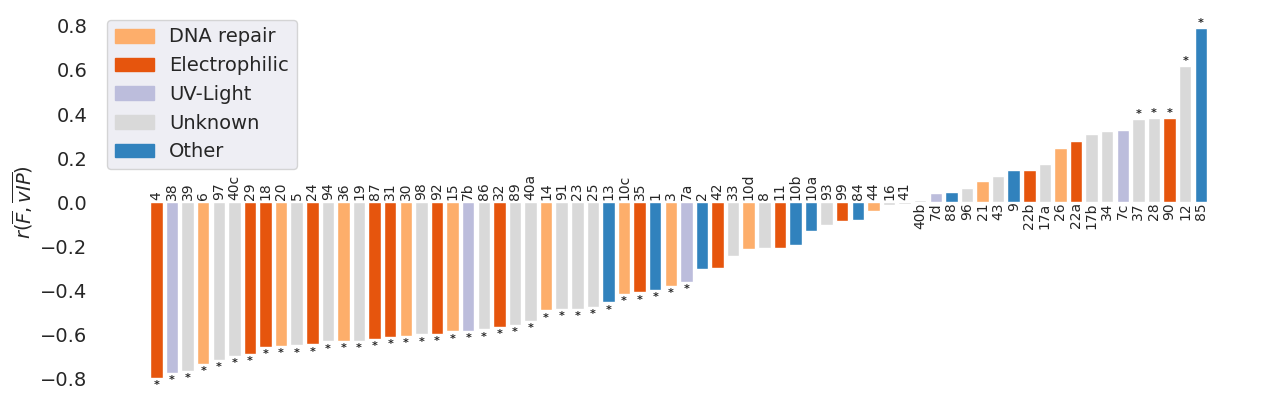

In [7]:
plot_cosmic_signature_correlations(
    stat_method="pearson",
    df=signature_stats,
    categories=["DNA repair", "Electrophilic", "UV-Light", "Unknown", "Other"],
    output_name="cosmic_sbs_etiologies_pearson.svg",
    transparent_background=False,
)

## Supplementary xx (type of SBS)


Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/T>A.svg


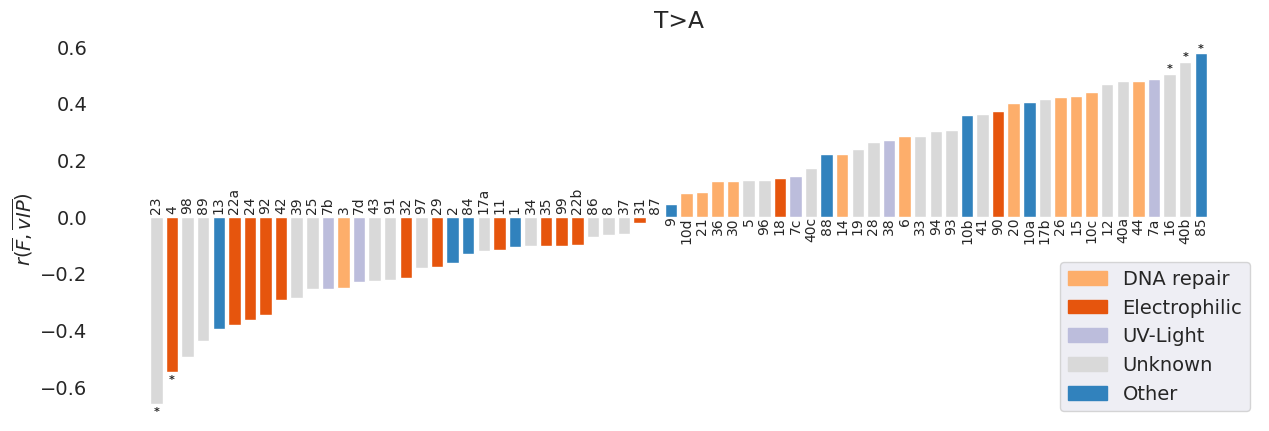

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/C>G.svg


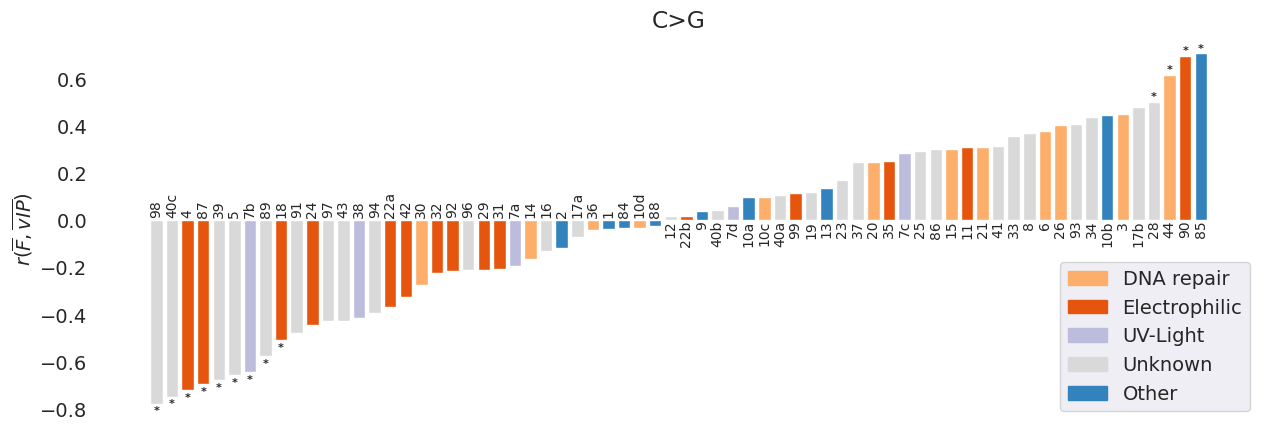

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/C>T.svg


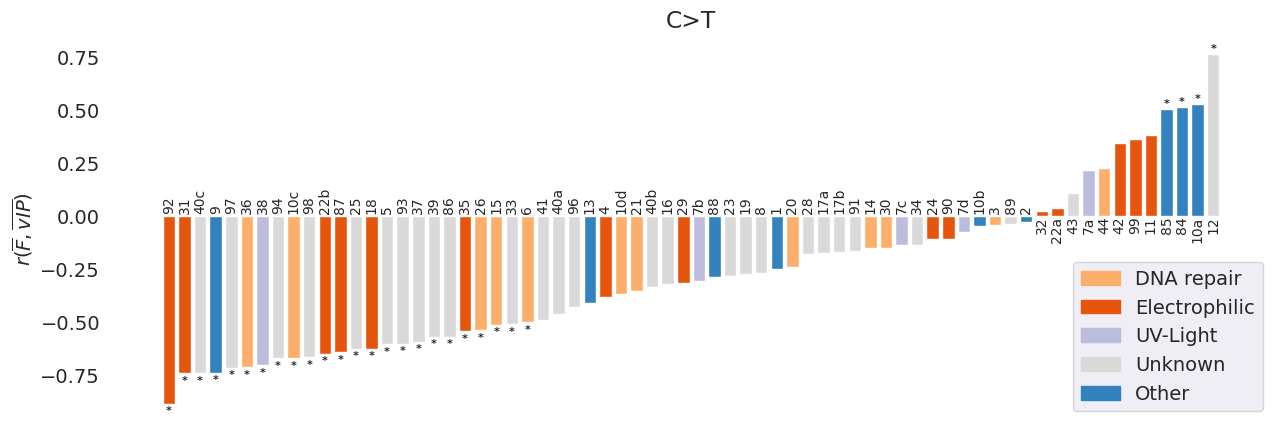

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/T>C.svg


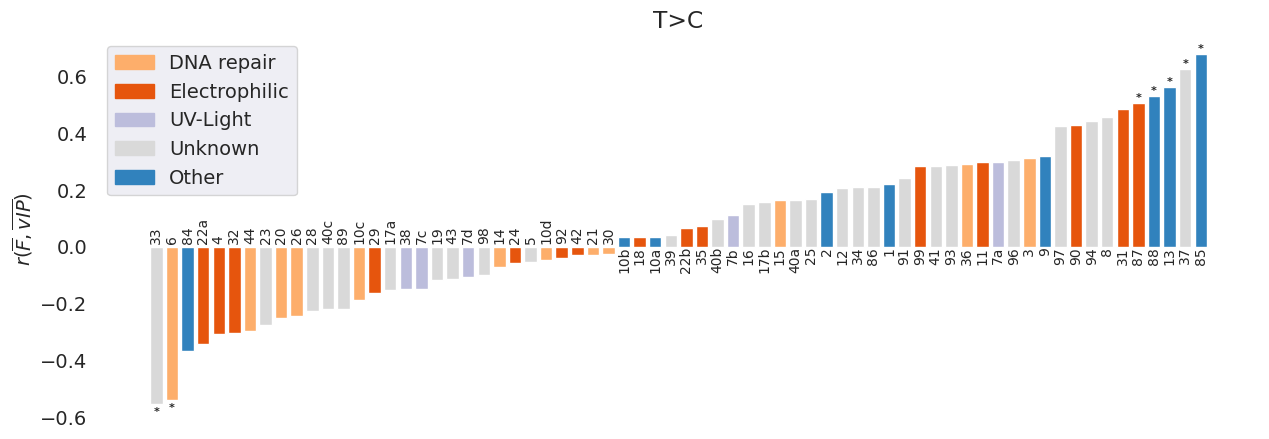

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/T>G.svg


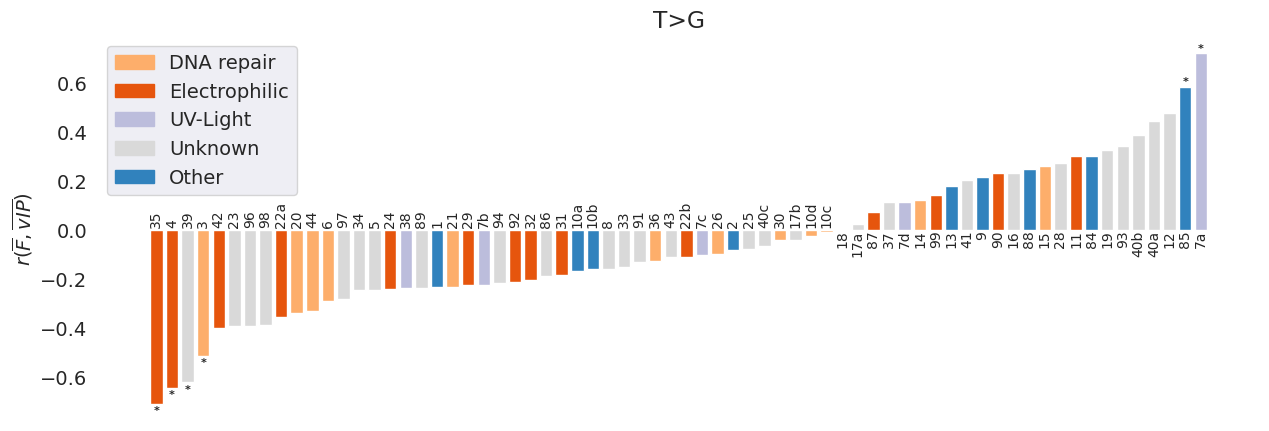

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/C>A.svg


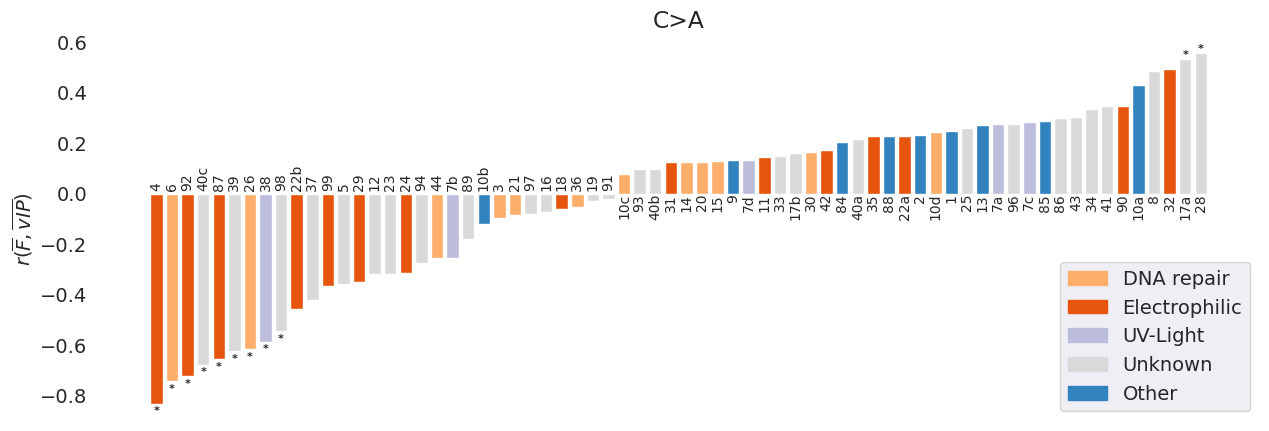

In [13]:
corr_dfs = []

for ref, alt in cosmic_signatures_df.select(["ref", "alt"]).unique().iter_rows():
    raw = (
        cosmic_signatures_df.filter(pl.col("alt") == alt, pl.col("ref") == ref)
        .join(kmer_context_bar, on="context")
        .with_columns(
            pl.col("context")
            .map_elements(VIPER.compute_double_strand_score, return_dtype=pl.Float64)
            .alias("vip")
        )
    )

    sig_cols = raw.select(
        pl.exclude("Type", "ref", "alt", "context", "total", "frequencies", "vip")
    ).columns

    total_coef_df = pl.DataFrame(
        {
            "signature": sig_cols,
            "total_coef": [raw[col].sum() for col in sig_cols],
        }
    )

    alt_corr_df = raw.with_columns(
        np.log(
            pl.exclude("Type", "ref", "alt", "context", "total", "frequencies", "vip")
            / pl.col("frequencies")
        )
    )

    alt_corr = get_corr_df(alt_corr_df, xs=sig_cols).join(total_coef_df, on="signature")

    corr_dfs.append(alt_corr.with_columns(pl.lit(f"{ref}>{alt}").alias("sbs_type")))

    plot_cosmic_signature_correlations(
        stat_method="pearson",
        df=signature_etiology.join(alt_corr, on="signature"),
        categories=["DNA repair", "Electrophilic", "UV-Light", "Unknown", "Other"],
        transparent_background=False,
        title=f"{ref}>{alt}",
        output_name=f"supplementary/{ref}>{alt}_threshold_05.svg",
        threshold=0.05,
    )
corr_decomposition = pl.concat(corr_dfs)

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/SBS_type_heatmap.svg


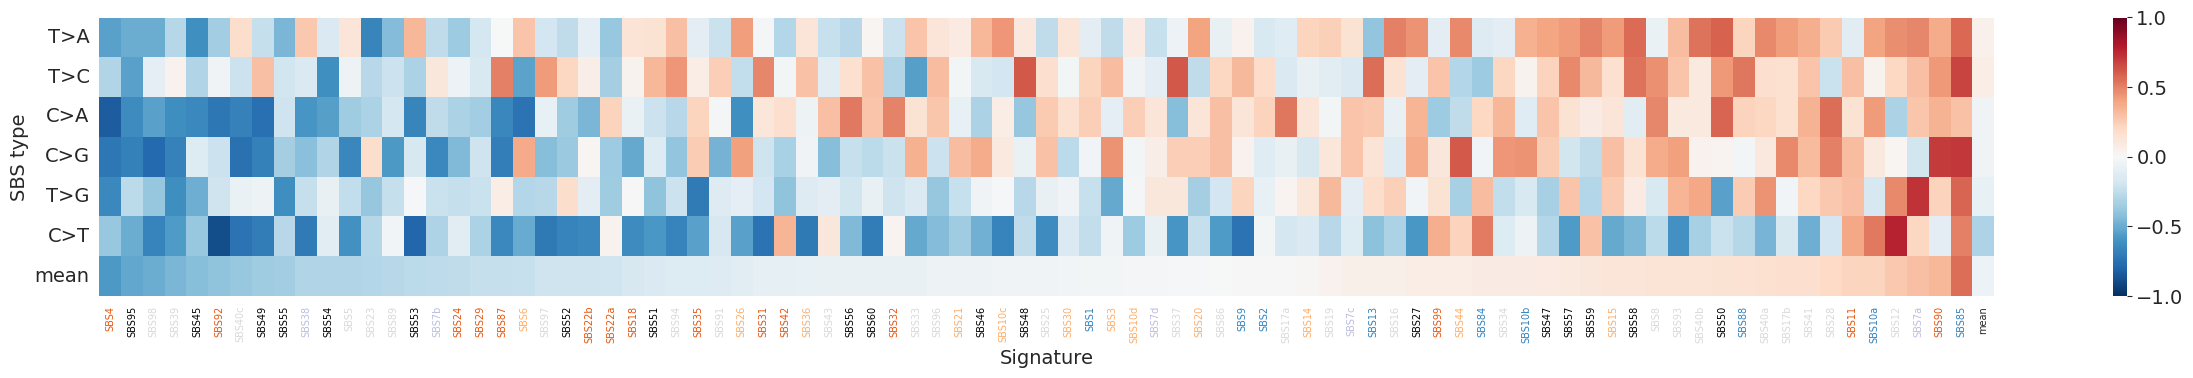

In [9]:
pivot = corr_decomposition.pivot(values="pearson", index="sbs_type", on="signature")
types = pivot["sbs_type"].to_list()
signatures = [c for c in pivot.columns if c != "sbs_type"]
matrix = pivot.select(signatures).to_numpy()

# Sort signatures by mean pearson across types
mean_per_sig = matrix.mean(axis=0)
order = np.argsort(mean_per_sig)
matrix = matrix[:, order]
signatures = [signatures[i] for i in order]

# Append mean column (horizontal mean per sbs_type)
mean_per_type = matrix.mean(axis=1)
matrix_with_col = np.hstack([matrix, mean_per_type.reshape(-1, 1)])

# Append mean row (vertical mean per signature + grand mean)
mean_row = np.append(mean_per_sig[order], mean_per_type.mean()).reshape(1, -1)
full_matrix = np.vstack([matrix_with_col, mean_row])

xticks = signatures + ["mean"]
yticks = types + ["mean"]

etiology_colors = {
    "DNA repair": mpl.cm.tab20c(6),
    "Electrophilic": mpl.cm.tab20c(4),
    "UV-Light": mpl.cm.tab20c(14),
    "Other": mpl.cm.tab20c(0),
    "Unknown": mpl.cm.tab20c(19),
    "artefact": mpl.cm.tab20c(2),
}
sig_to_classification = dict(
    signature_etiology.select(["signature", "classification"]).iter_rows()
)

fig, ax = plt.subplots(figsize=(25, 4))
sbs.heatmap(
    full_matrix,
    xticklabels=xticks,
    yticklabels=yticks,
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0,
    ax=ax,
)
ax.tick_params(axis="x", rotation=90, labelsize=7)
ax.set_xlabel("Signature")
ax.set_ylabel("SBS type")

for label in ax.get_xticklabels():
    sig = label.get_text()
    classification = sig_to_classification.get(sig)
    if classification is not None:
        label.set_color(etiology_colors.get(classification, "black"))

plt.tight_layout()
if GENERATE_RESULTS:
    output_path = (
        PROJECT_DIR / "outputs" / "cosmic" / "supplementary" / f"SBS_type_heatmap.svg"
    )
    if not output_path.parent.exists():
        output_path.parent.mkdir(parents=True)
    fig.savefig(output_path, bbox_inches="tight", transparent=False)
    print(f"Figure saved to {output_path}")
plt.show()

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/mean_sbs_category_width.svg


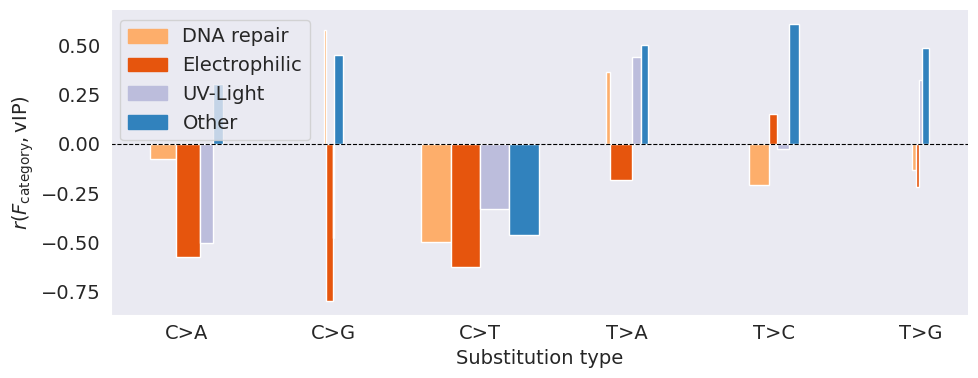

In [10]:
MIN_PROB = 1e-6

categories = ["DNA repair", "Electrophilic", "UV-Light", "Other"]

# Map classification → list of signature columns
sig_to_class = dict(
    signature_etiology.select(["signature", "classification"]).iter_rows()
)
all_sig_cols = cosmic_signatures_df.select(
    pl.exclude("Type", "context", "ref", "alt")
).columns
cat_to_sigs = {
    cat: [s for s in all_sig_cols if sig_to_class.get(s) == cat] for cat in categories
}  # {electro : [SBS4,...] ,...}

bars = []

for ref, alt in sorted(
    cosmic_signatures_df.select(["ref", "alt"]).unique().iter_rows()
):
    sbs_type = f"{ref}>{alt}"

    sub_df = (
        cosmic_signatures_df.filter(pl.col("ref") == ref, pl.col("alt") == alt)
        .join(kmer_context_bar, on="context")
        .with_columns(
            pl.col("context")
            .map_elements(VIPER.compute_double_strand_score, return_dtype=pl.Float64)
            .alias("vip")
        )
    )

    for cat in categories:
        sigs = cat_to_sigs[cat]
        if not sigs:
            continue

        sub_cat = sub_df.with_columns(
            pl.sum_horizontal([pl.col(s) for s in sigs]).alias("sum_prob")
        )  # Compute the sum of probability for this REF>ALT in this category
        total_coef = sub_cat[
            "sum_prob"
        ].sum()  # Importance of this REF>ALT for this category

        sub_cat = (
            sub_cat.filter(pl.col("sum_prob") > MIN_PROB)
            .with_columns(np.log(pl.col("sum_prob") / pl.col("frequencies")).alias("F"))
            .filter(pl.col("F").is_finite())
        )

        if len(sub_cat) < 3:
            continue

        r, p = stats.pearsonr(sub_cat["F"].to_numpy(), sub_cat["vip"].to_numpy())
        bars.append(
            {
                "sbs_type": sbs_type,
                "classification": cat,
                "pearson": r,
                "pvalue": p,
                "total_coef": total_coef,
            }
        )

mean_df = pl.DataFrame(bars)

# --- Plot ---
sbs_types = sorted(mean_df["sbs_type"].unique().to_list())
GROUP_WIDTH = 0.8
base_w = GROUP_WIDTH / len(categories)

# Normalize widths within each etiology: max bar of each etiology = base_w
cat_max = {
    cat: mean_df.filter(pl.col("classification") == cat)["total_coef"].max()
    for cat in categories
}

fig, ax = plt.subplots(figsize=(10, 4))

for xi, sbs_type in enumerate(sbs_types):
    type_df = mean_df.filter(pl.col("sbs_type") == sbs_type)

    widths = {}
    for cat in categories:
        cat_row = type_df.filter(pl.col("classification") == cat)
        widths[cat] = (cat_row["total_coef"].item() / cat_max[cat]) * base_w

    total_group_w = sum(widths.values())
    running = xi - total_group_w / 2

    for cat in categories:
        if widths[cat] == 0:
            continue
        cat_row = type_df.filter(pl.col("classification") == cat)
        r_val = cat_row["pearson"].item()
        w = widths[cat]
        x_center = running + w / 2
        ax.bar(
            x_center,
            r_val,
            width=w,
            color=etiology_colors[cat],
            label=cat if xi == 0 else None,
        )
        running += w

ax.set_xticks(range(len(sbs_types)))
ax.set_xticklabels(sbs_types)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.set_ylabel(r"$r(F_{\mathrm{category}}, \mathrm{vIP})$")
ax.set_xlabel("Substitution type")
handles = [mpatches.Patch(color=etiology_colors[cat], label=cat) for cat in categories]
ax.legend(handles=handles)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
if GENERATE_RESULTS:
    output_path = (
        PROJECT_DIR
        / "outputs"
        / "cosmic"
        / "supplementary"
        / "mean_sbs_category_width.svg"
    )
    if not output_path.parent.exists():
        output_path.parent.mkdir(parents=True)
    fig.savefig(output_path, bbox_inches="tight", transparent=False)
    print(f"Figure saved to {output_path}")
plt.show()

### Correlation per substitution type and etiology category

For each substitution type (e.g. C>A) and etiology category (DNA repair, Electrophilic, UV-Light, Other):

1. All signatures belonging to the category are summed per trinucleotide context → `sum_prob` (e.g. for C>A : ACT = sum of ACT for each signature of the category)
2. F is computed as **F = log(sum_prob / kmer_freq)**
3. F is correlated with vIP across the 16 trinucleotide contexts of that substitution type

**Bar height**: Pearson r between F and vIP — reflects whether the mutation enrichment pattern of that etiology aligns with vIP predicted accessibility.

**Bar width**: proportional to `total_coef` (sum of `sum_prob` across all contexts), reflects the relative weight of that substitution type for this a.

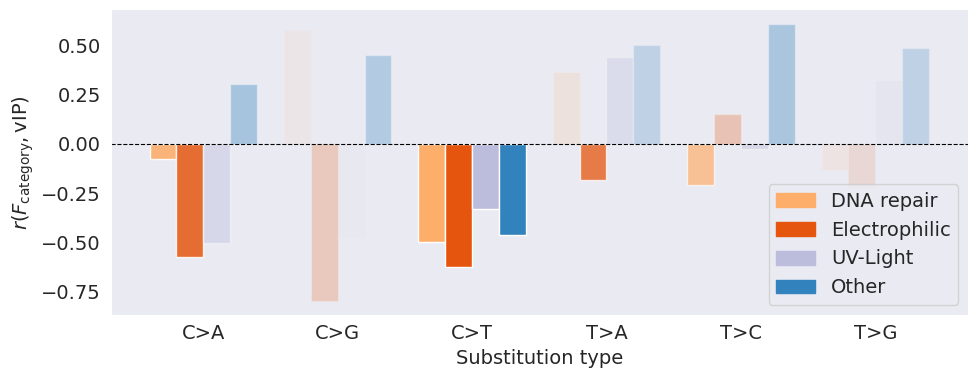

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/mean_sbs_category_opacity.svg


In [11]:
n_cats = len(categories)
fixed_w = GROUP_WIDTH / n_cats
offsets = np.linspace(-(n_cats - 1) / 2, (n_cats - 1) / 2, n_cats) * fixed_w

fig, ax = plt.subplots(figsize=(10, 4))

for xi, sbs_type in enumerate(sbs_types):
    type_df = mean_df.filter(pl.col("sbs_type") == sbs_type)

    for offset, cat in zip(offsets, categories):
        cat_row = type_df.filter(pl.col("classification") == cat)
        if len(cat_row) == 0:
            continue
        alpha = cat_row["total_coef"].item() / cat_max[cat]
        r_val = cat_row["pearson"].item()
        ax.bar(
            xi + offset,
            r_val,
            width=fixed_w,
            color=etiology_colors[cat],
            alpha=alpha,
            label=cat if xi == 0 else None,
        )

ax.set_xticks(range(len(sbs_types)))
ax.set_xticklabels(sbs_types)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.set_ylabel(r"$r(F_{\mathrm{category}}, \mathrm{vIP})$")
ax.set_xlabel("Substitution type")
handles = [mpatches.Patch(color=etiology_colors[cat], label=cat) for cat in categories]
ax.legend(handles=handles)
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
if GENERATE_RESULTS:
    output_path = (
        PROJECT_DIR
        / "outputs"
        / "cosmic"
        / "supplementary"
        / "mean_sbs_category_opacity.svg"
    )
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, bbox_inches="tight", transparent=False)
    print(f"Figure saved to {output_path}")

1e-06

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS1_no_outlier.svg


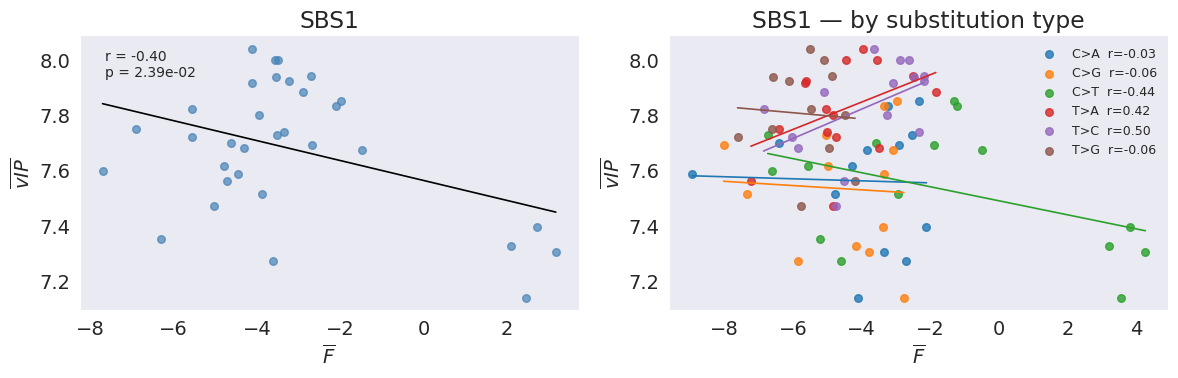

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS2_no_outlier.svg


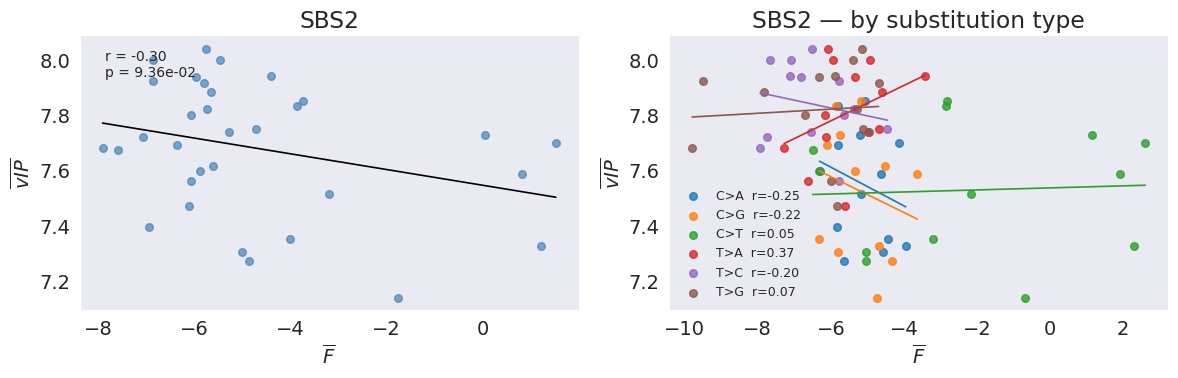

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS3_no_outlier.svg


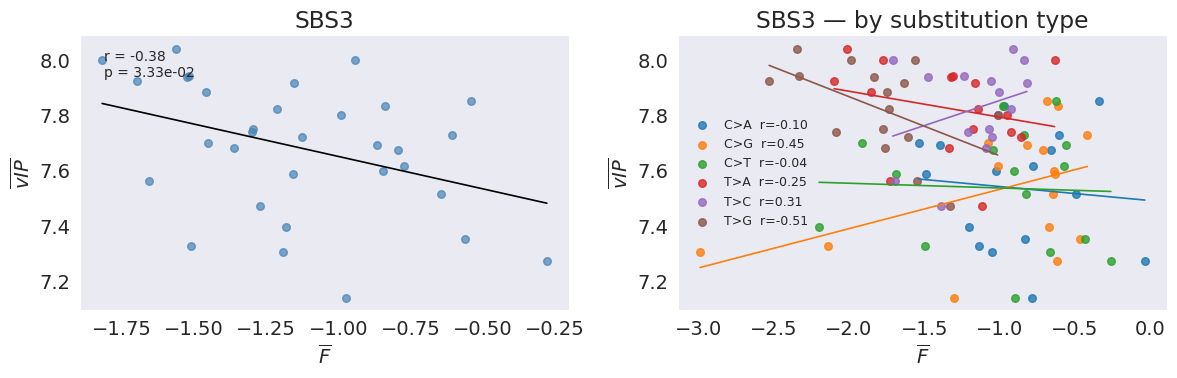

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS4_no_outlier.svg


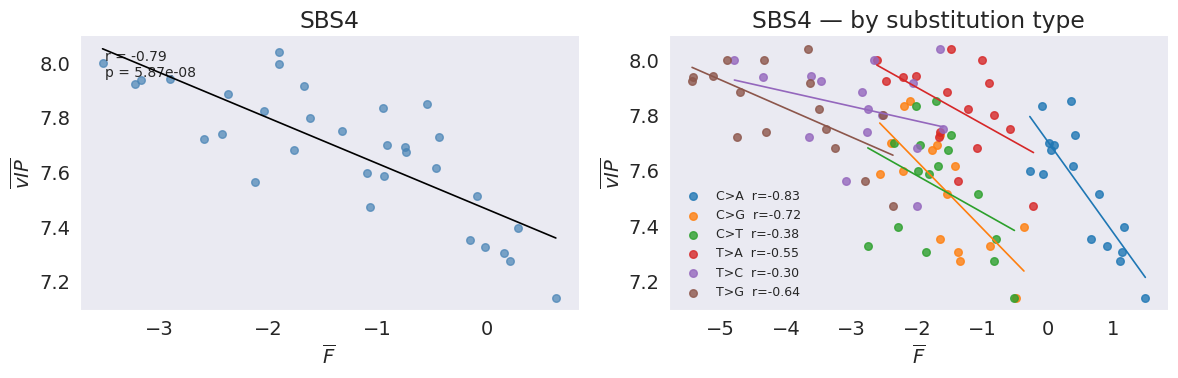

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS5_no_outlier.svg


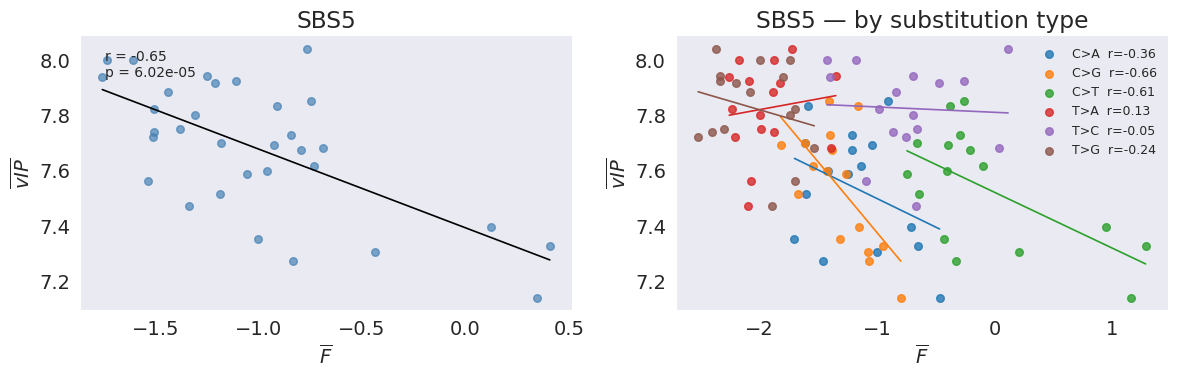

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS6_no_outlier.svg


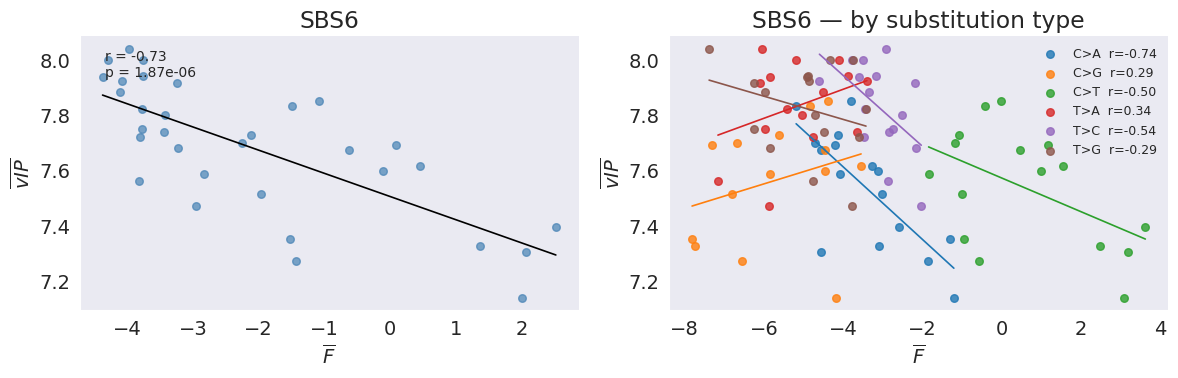

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS7a_no_outlier.svg


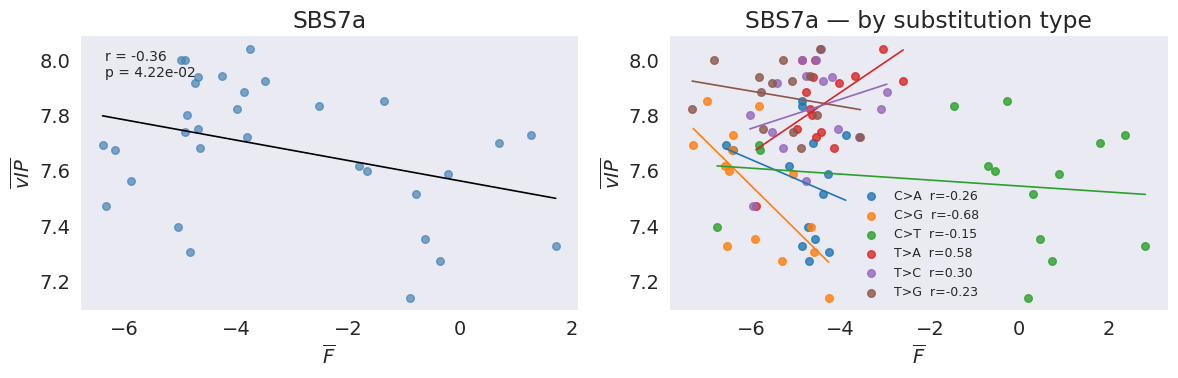

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS7b_no_outlier.svg


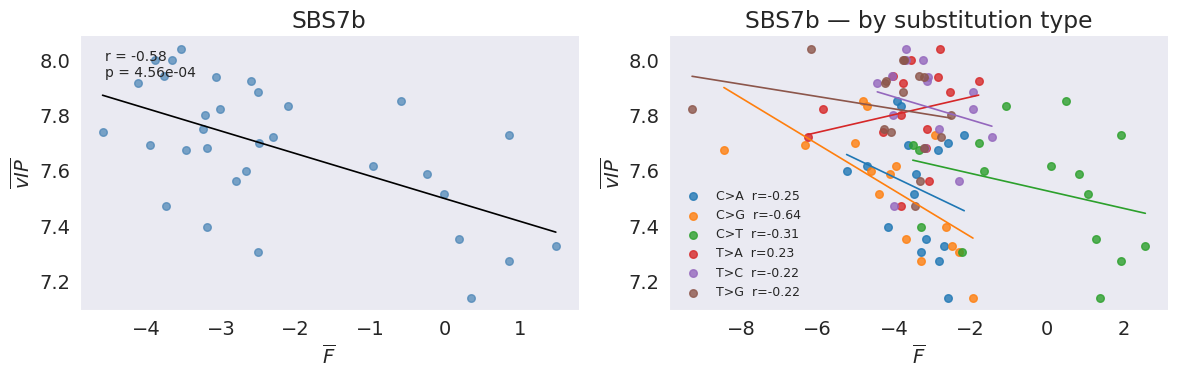

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS7c_no_outlier.svg


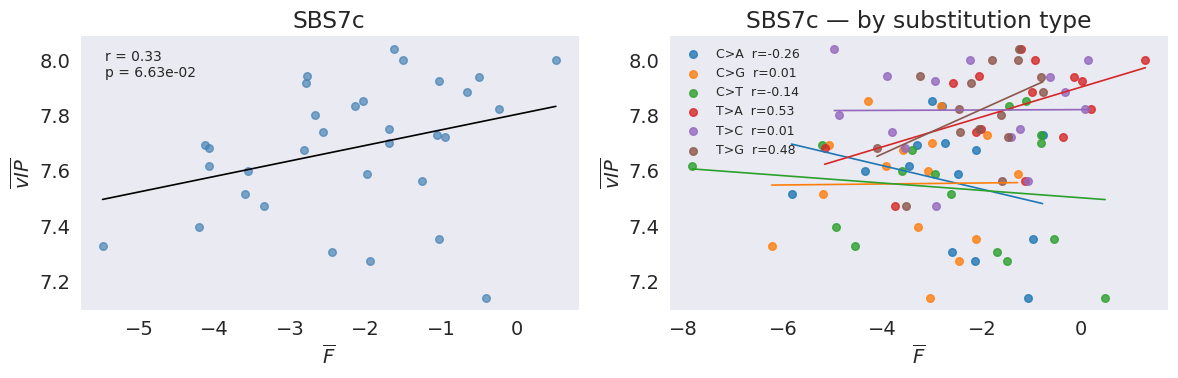

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS7d_no_outlier.svg


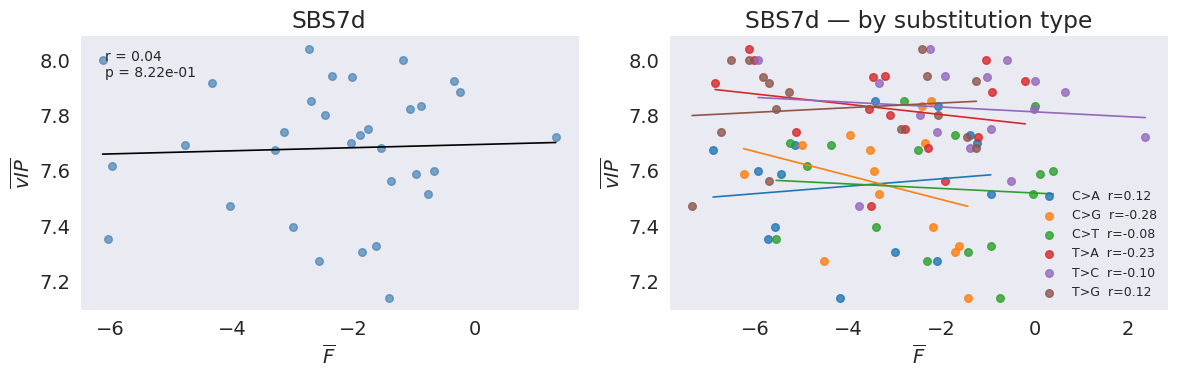

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS8_no_outlier.svg


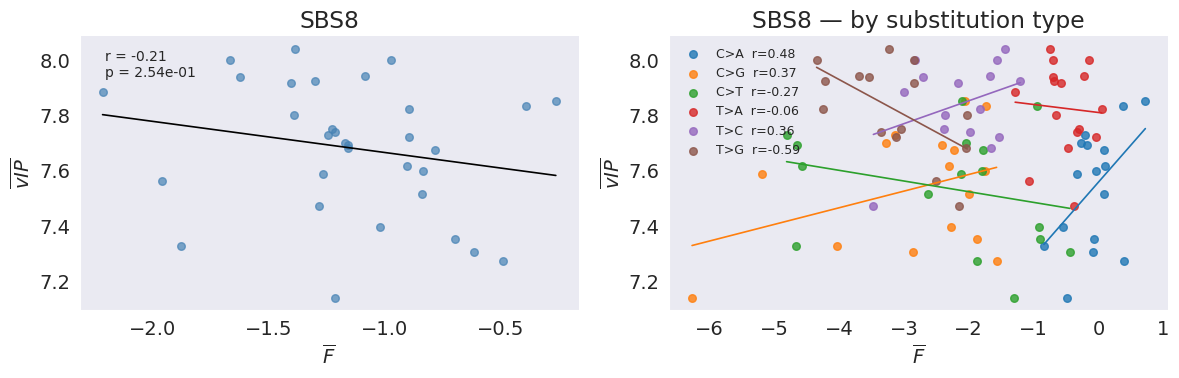

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS9_no_outlier.svg


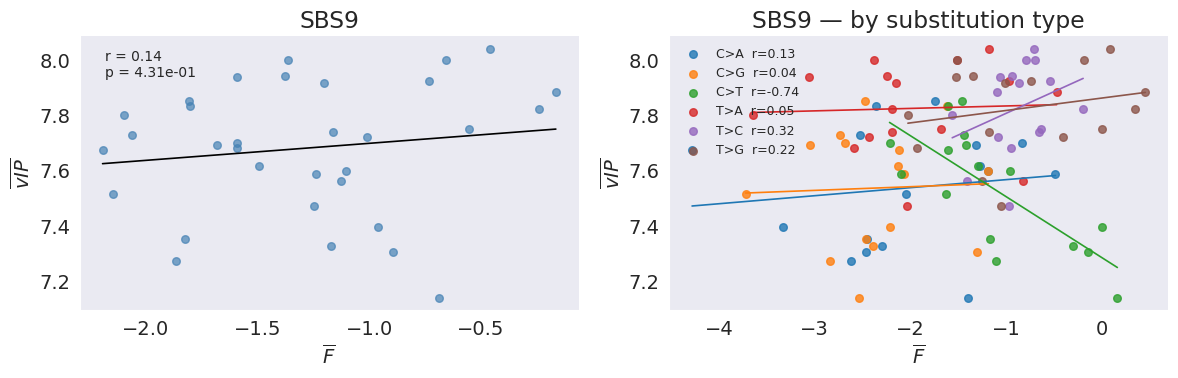

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS10a_no_outlier.svg


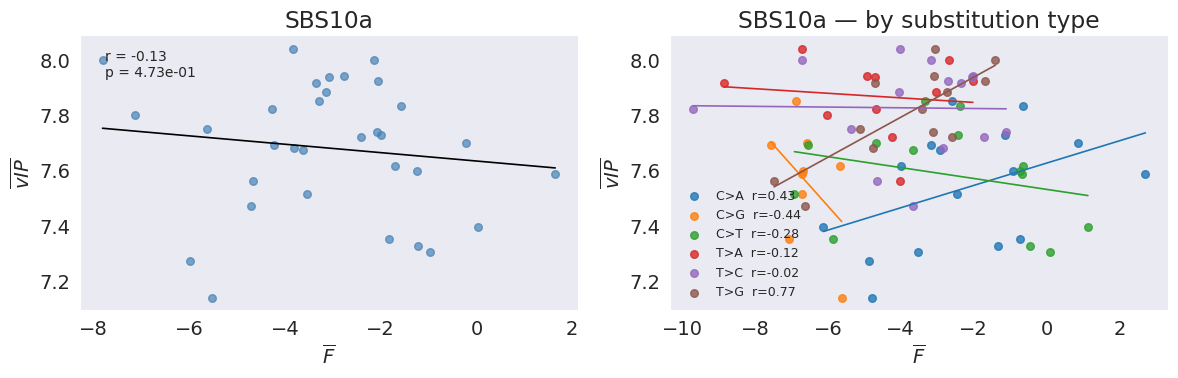

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS10b_no_outlier.svg


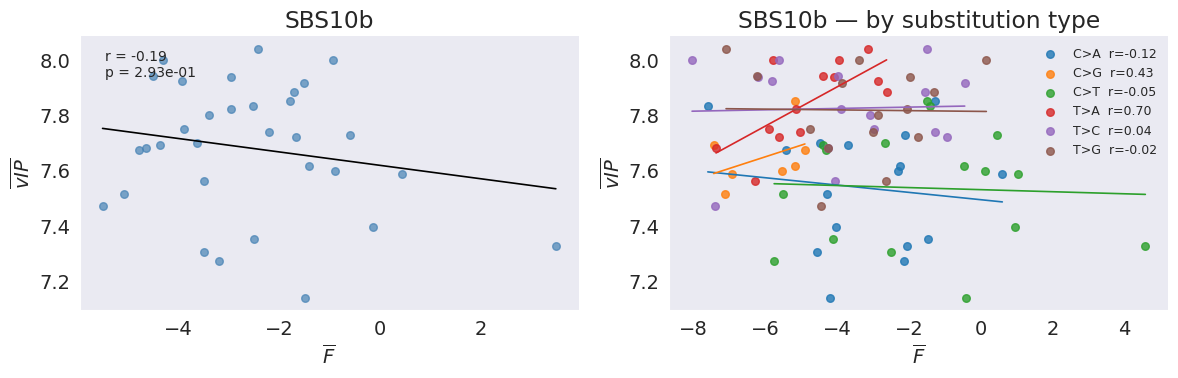

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS10c_no_outlier.svg


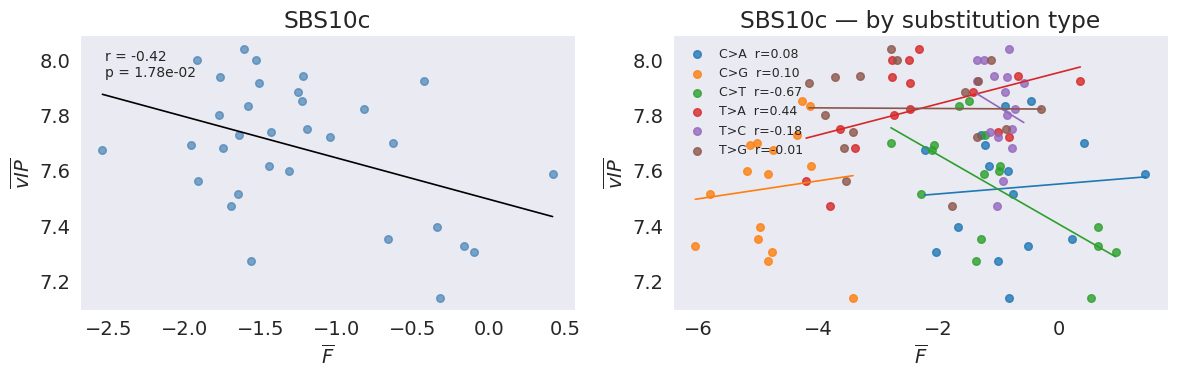

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS10d_no_outlier.svg


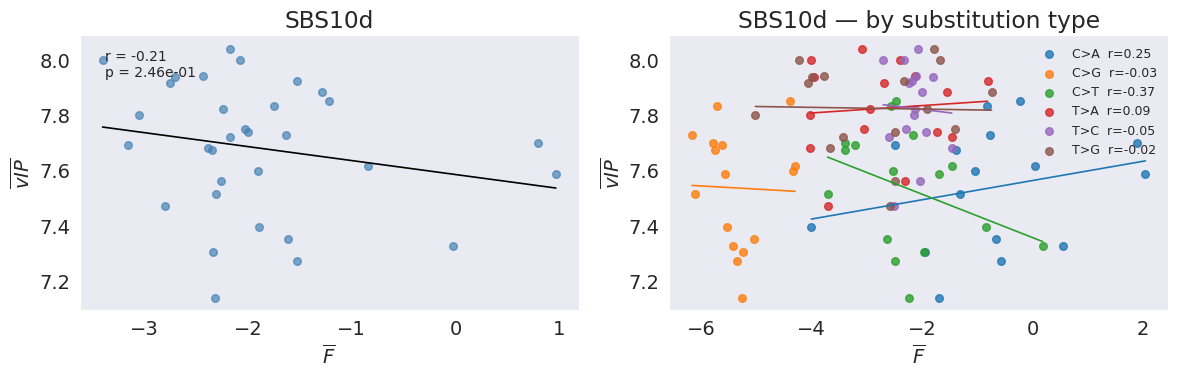

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS11_no_outlier.svg


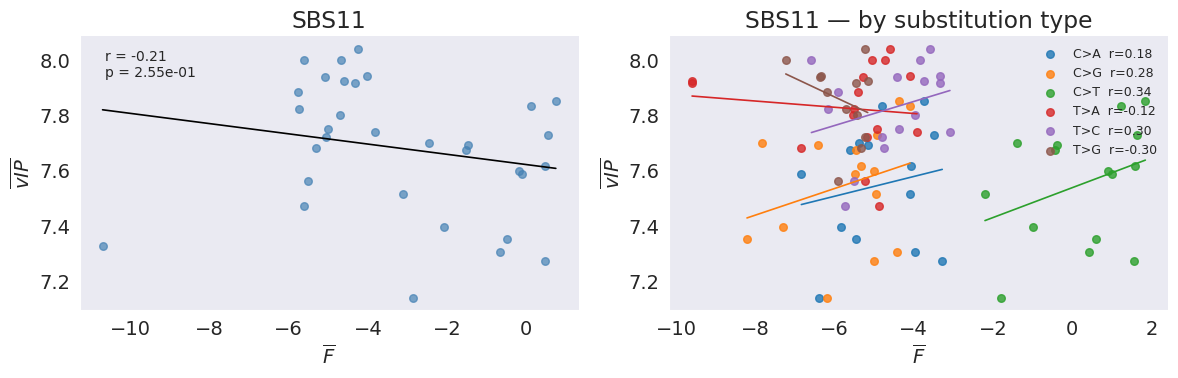

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS12_no_outlier.svg


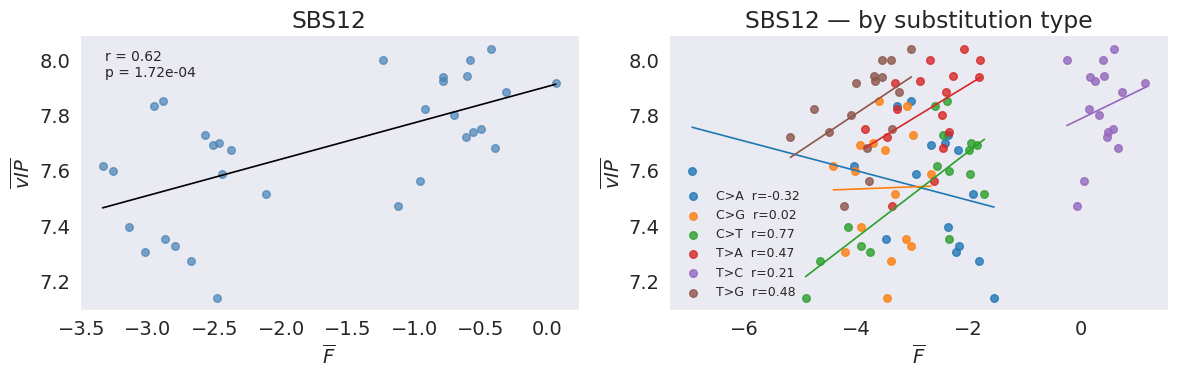

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS13_no_outlier.svg


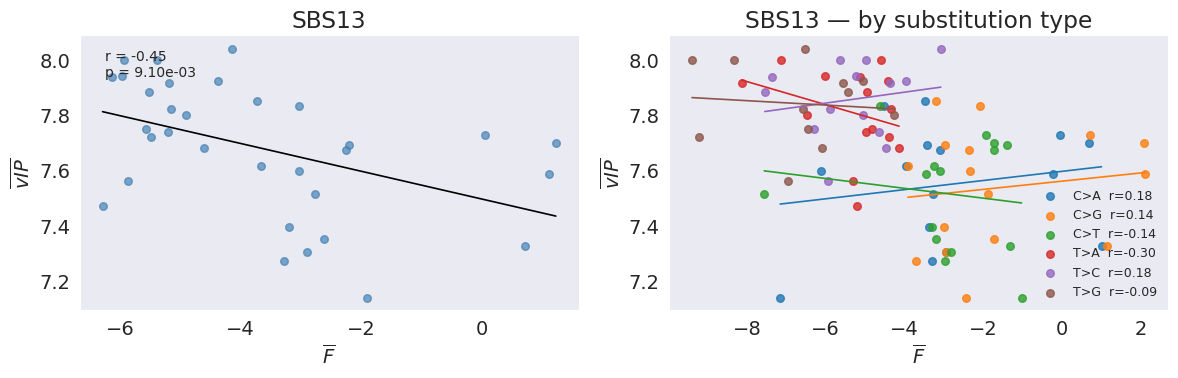

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS14_no_outlier.svg


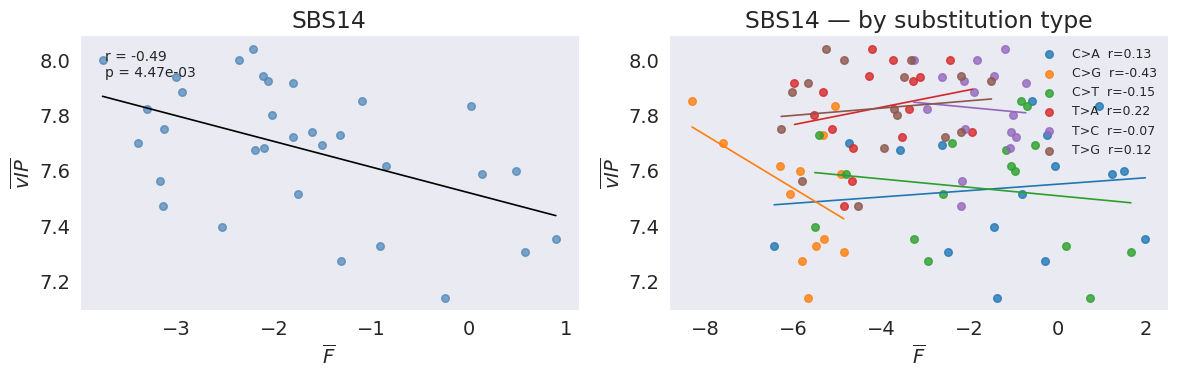

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS15_no_outlier.svg


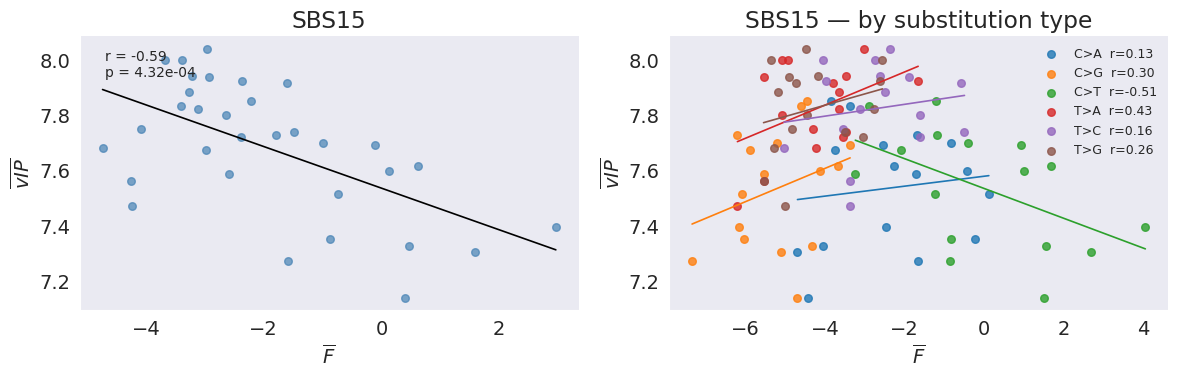

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS16_no_outlier.svg


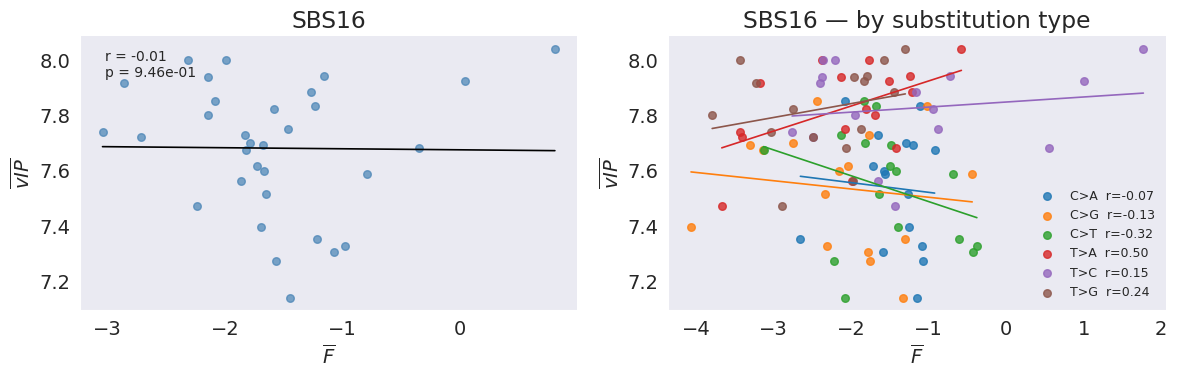

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS17a_no_outlier.svg


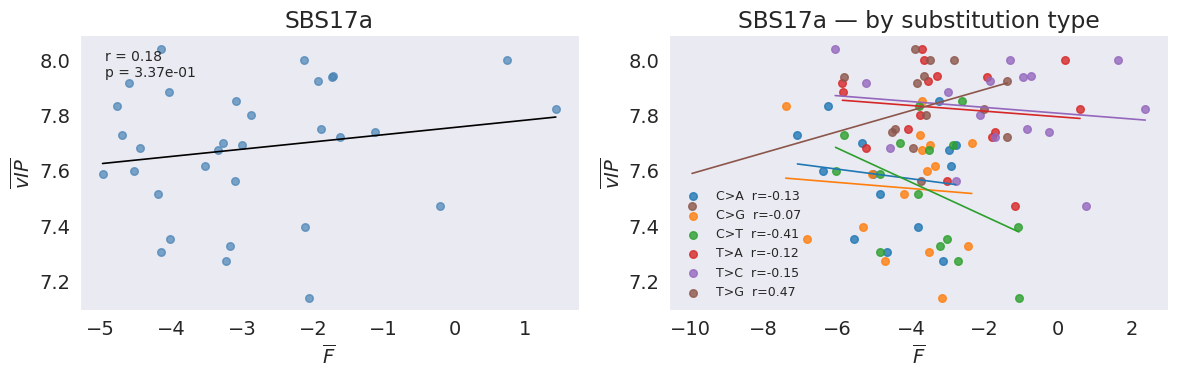

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS17b_no_outlier.svg


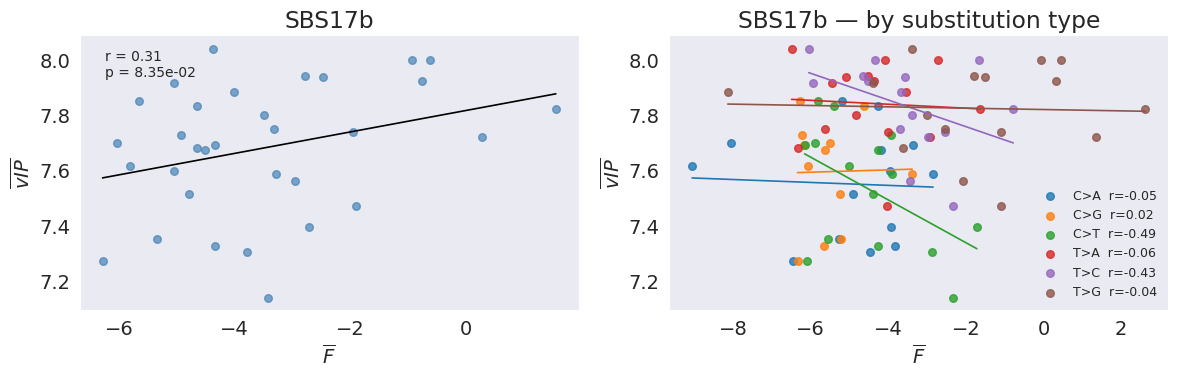

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS18_no_outlier.svg


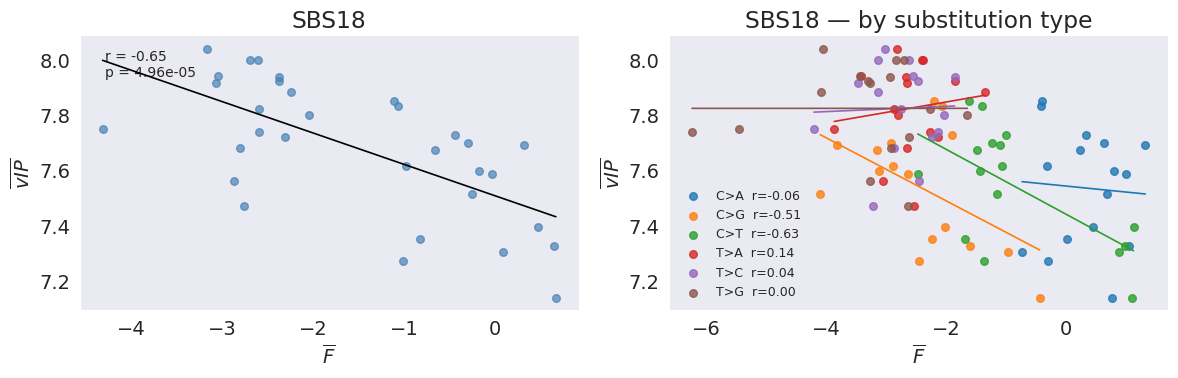

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS19_no_outlier.svg


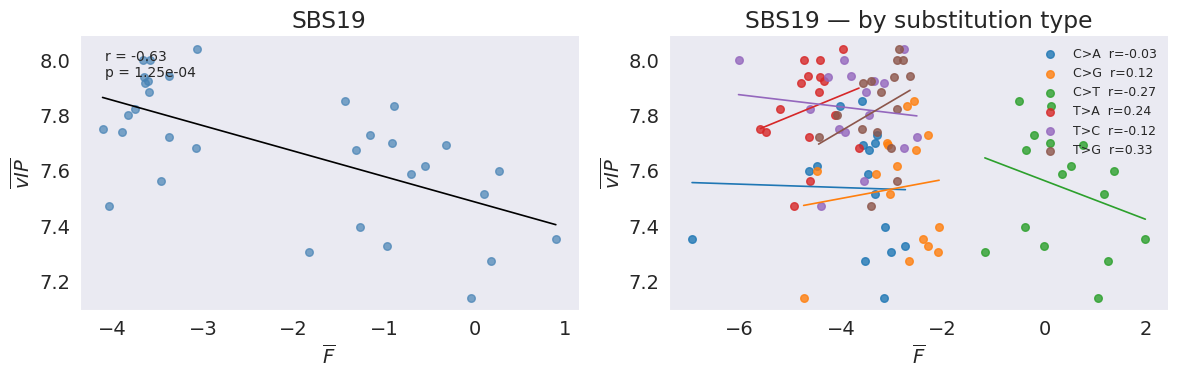

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS20_no_outlier.svg


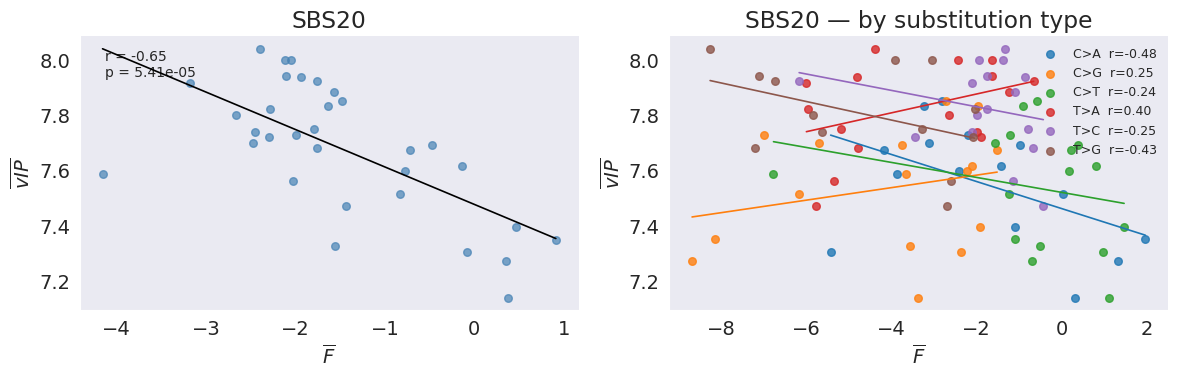

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS21_no_outlier.svg


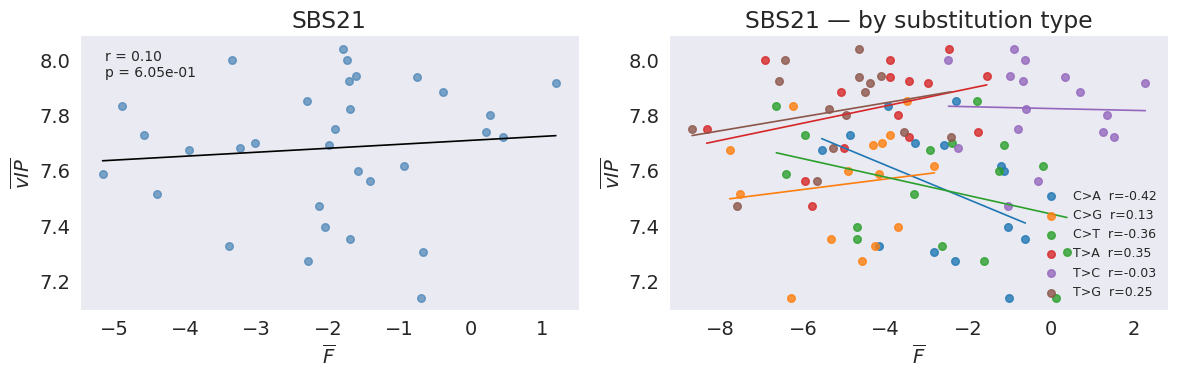

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS22a_no_outlier.svg


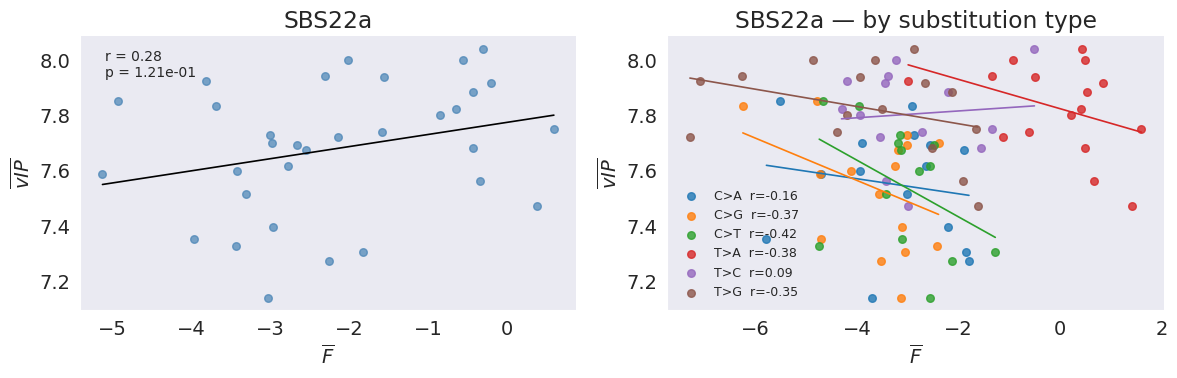

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS22b_no_outlier.svg


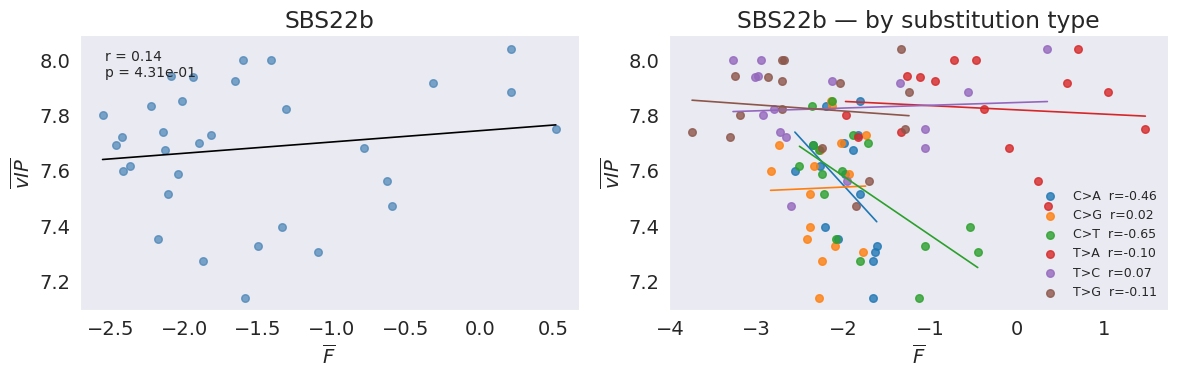

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS23_no_outlier.svg


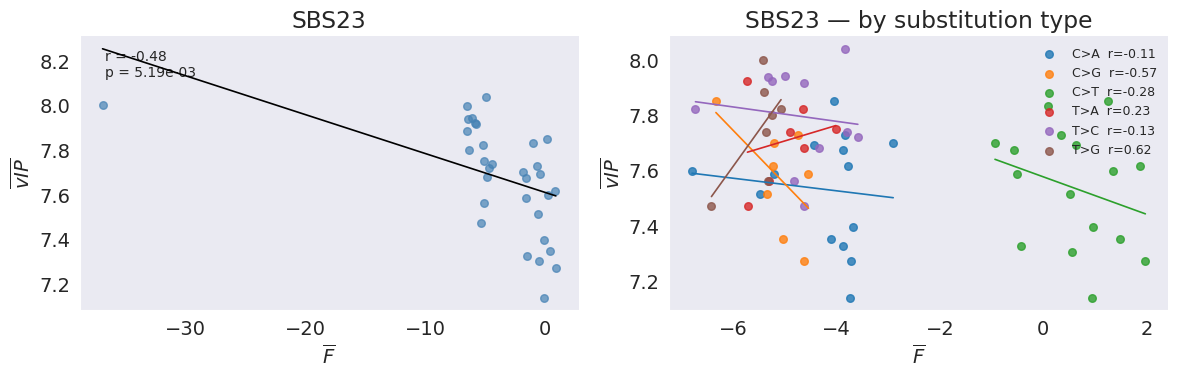

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS24_no_outlier.svg


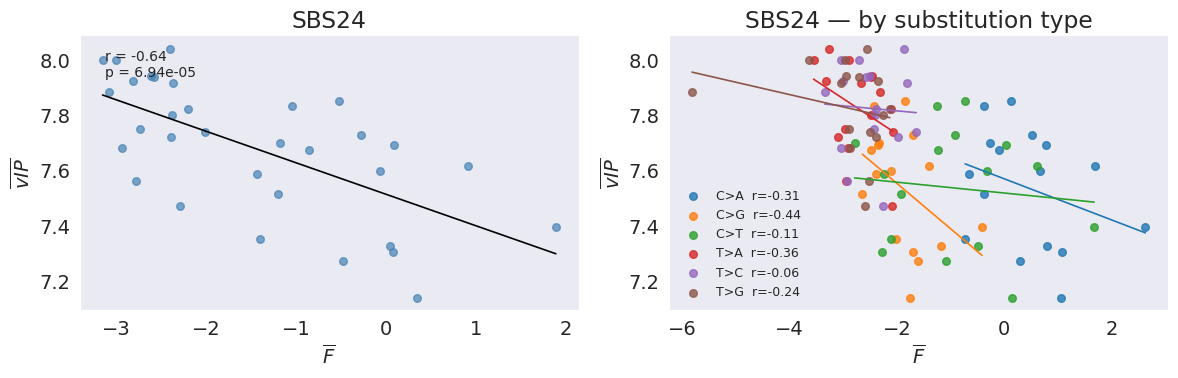

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS25_no_outlier.svg


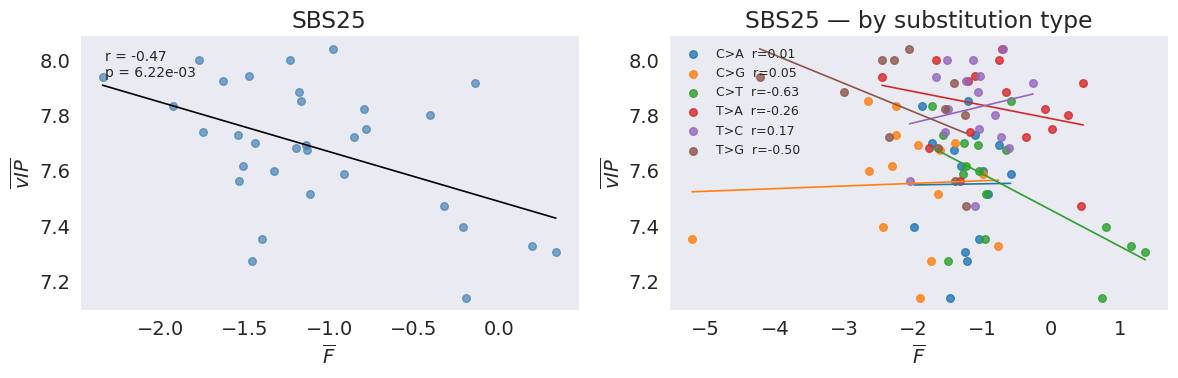

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS26_no_outlier.svg


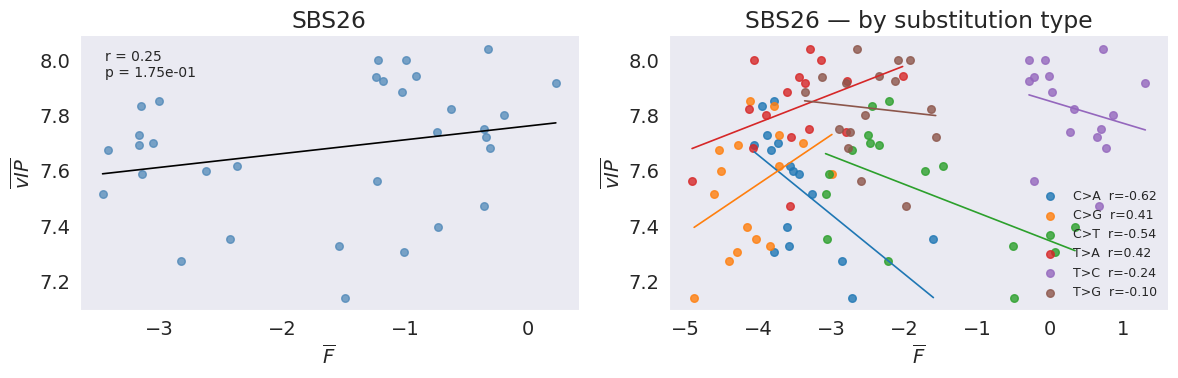

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS27_no_outlier.svg


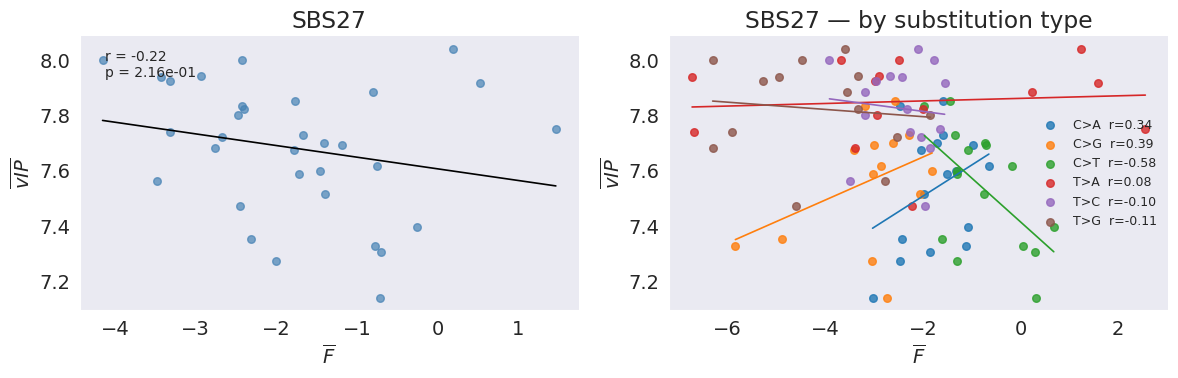

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS28_no_outlier.svg


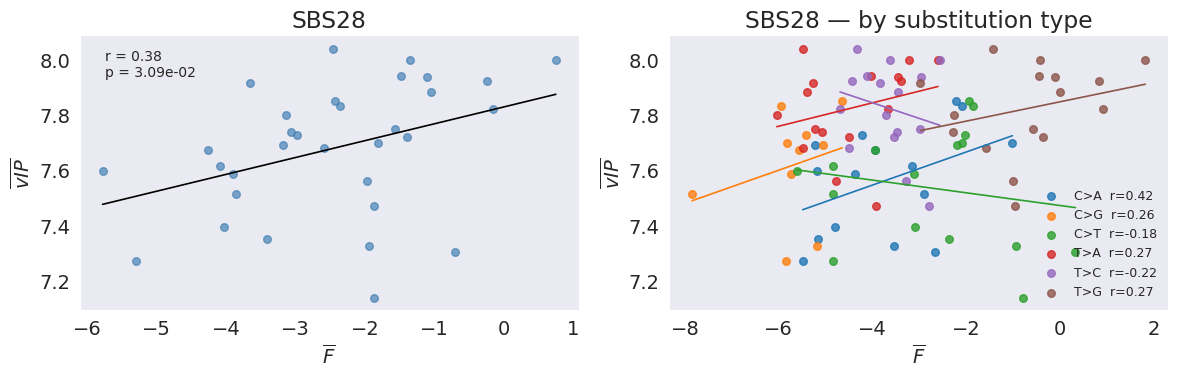

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS29_no_outlier.svg


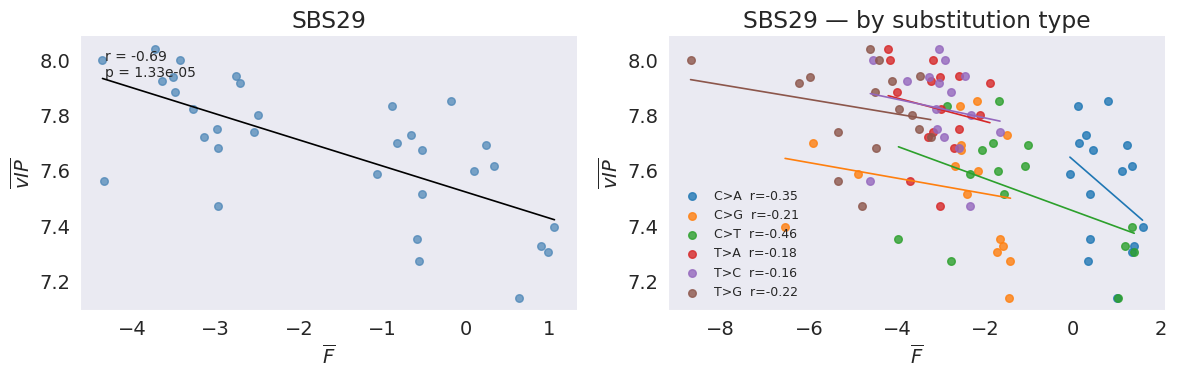

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS30_no_outlier.svg


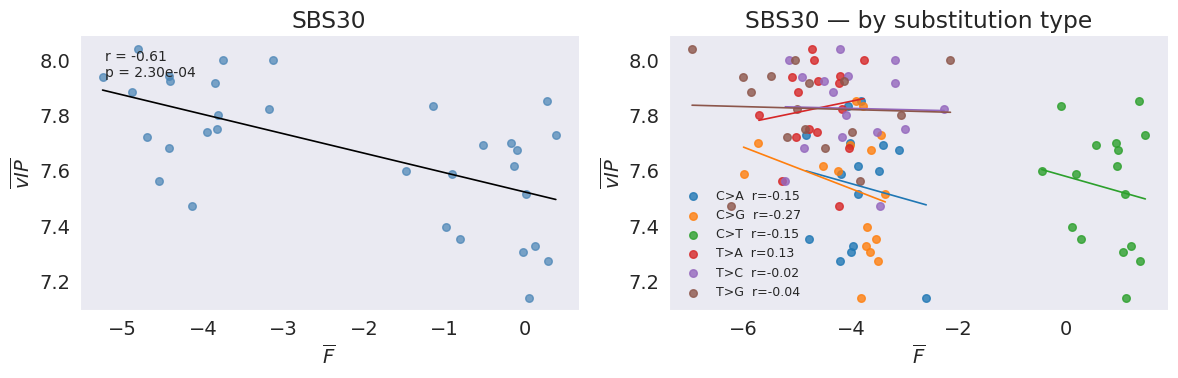

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS31_no_outlier.svg


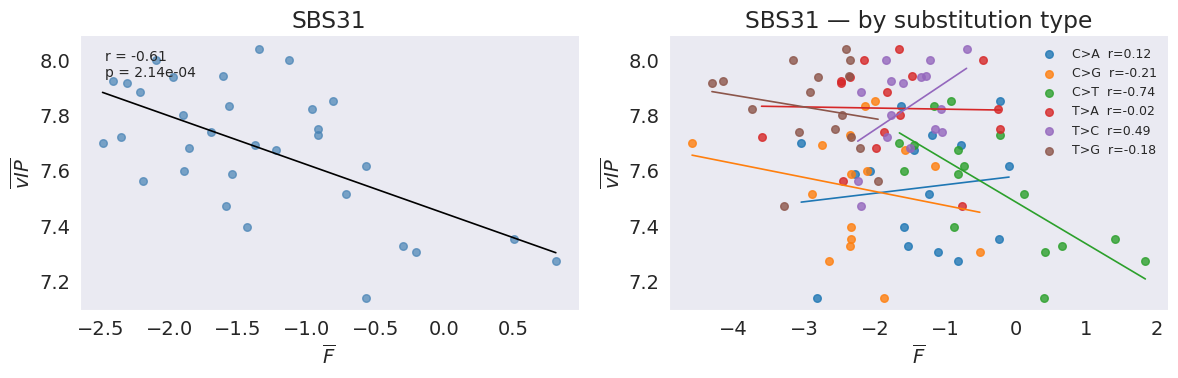

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS32_no_outlier.svg


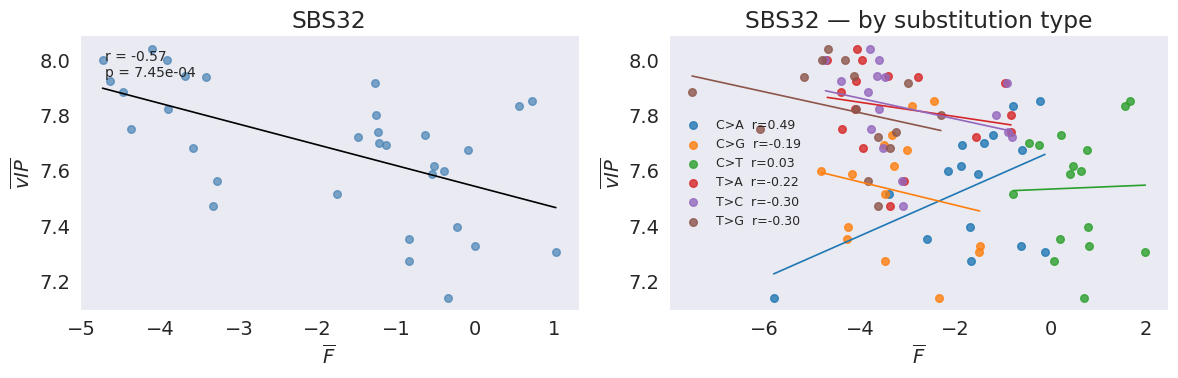

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS33_no_outlier.svg


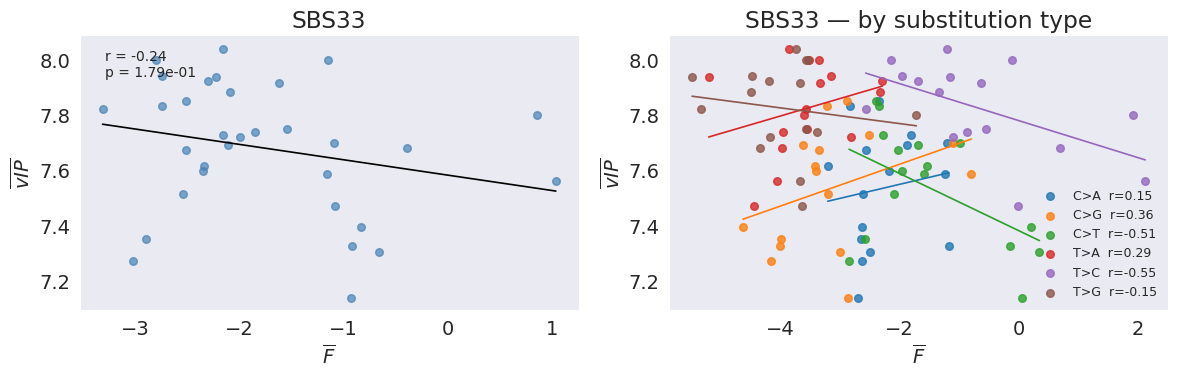

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS34_no_outlier.svg


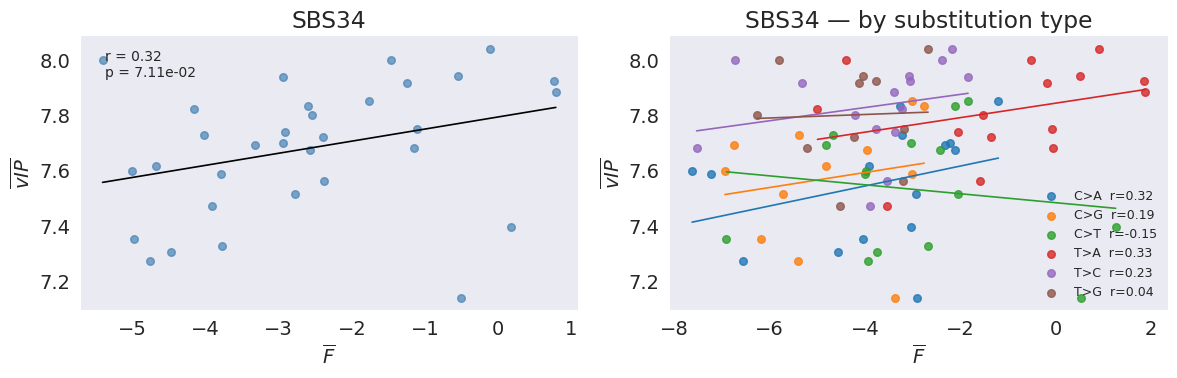

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS35_no_outlier.svg


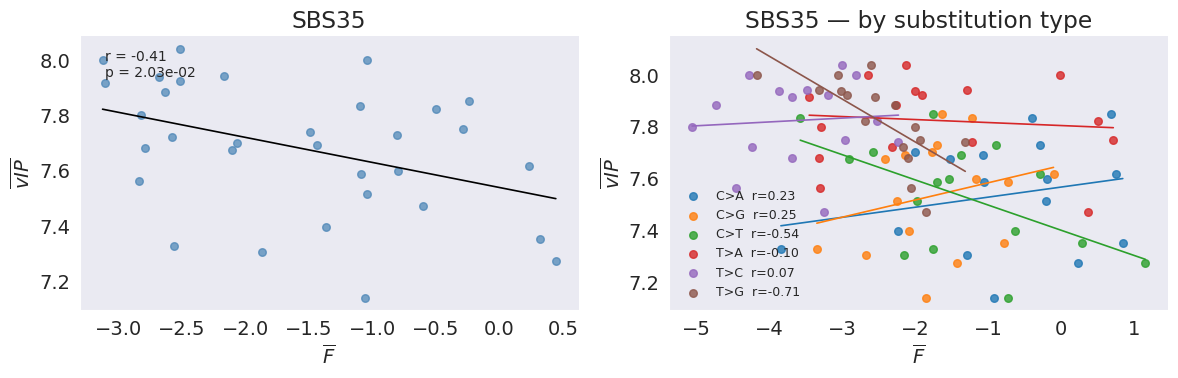

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS36_no_outlier.svg


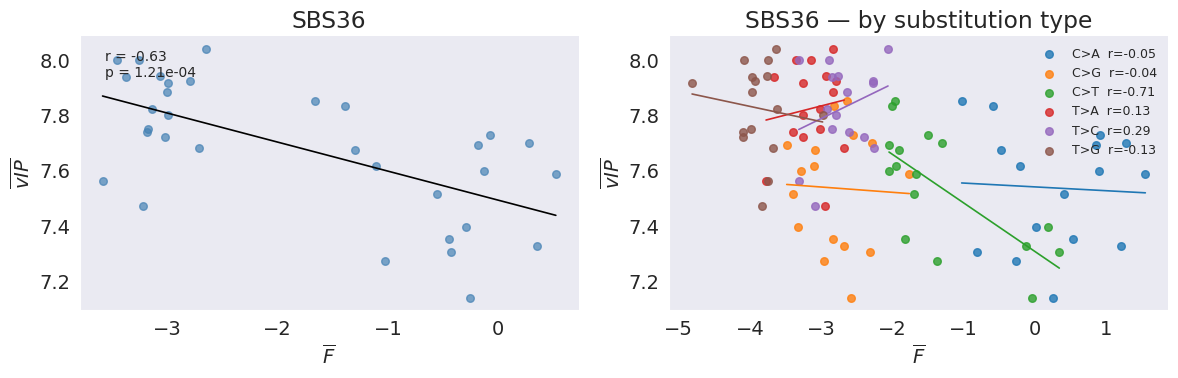

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS37_no_outlier.svg


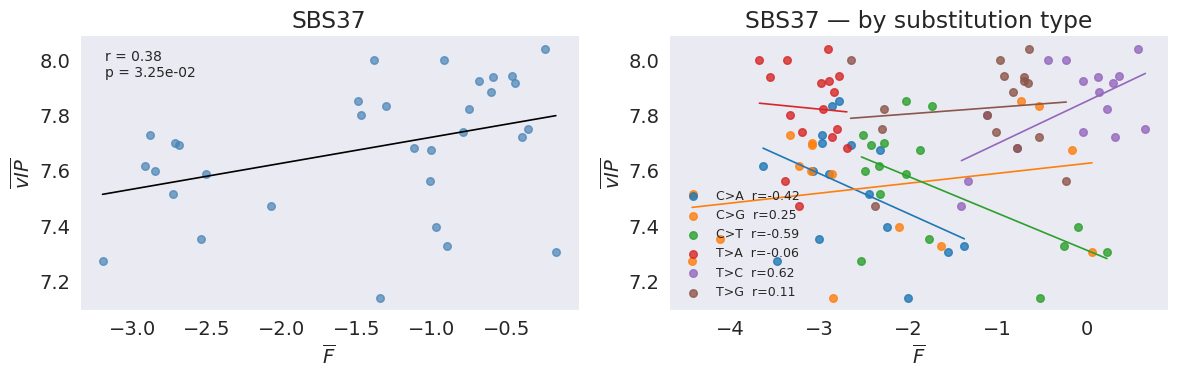

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS38_no_outlier.svg


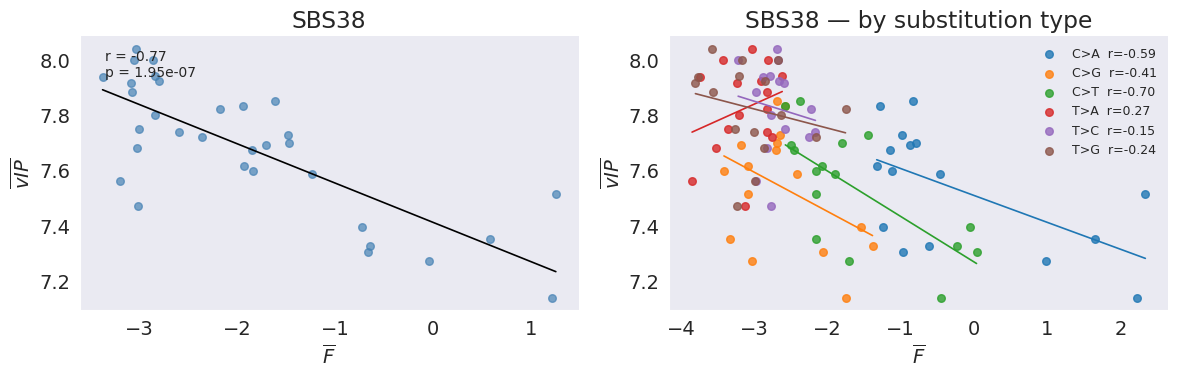

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS39_no_outlier.svg


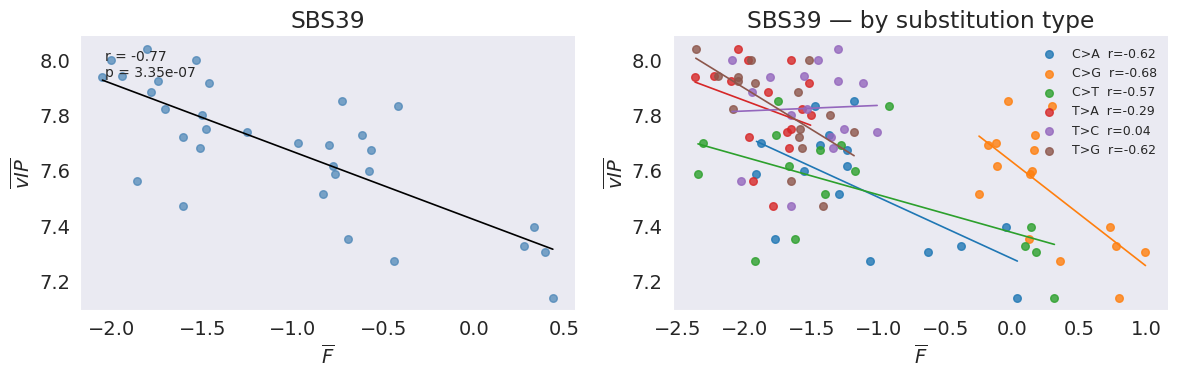

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS40a_no_outlier.svg


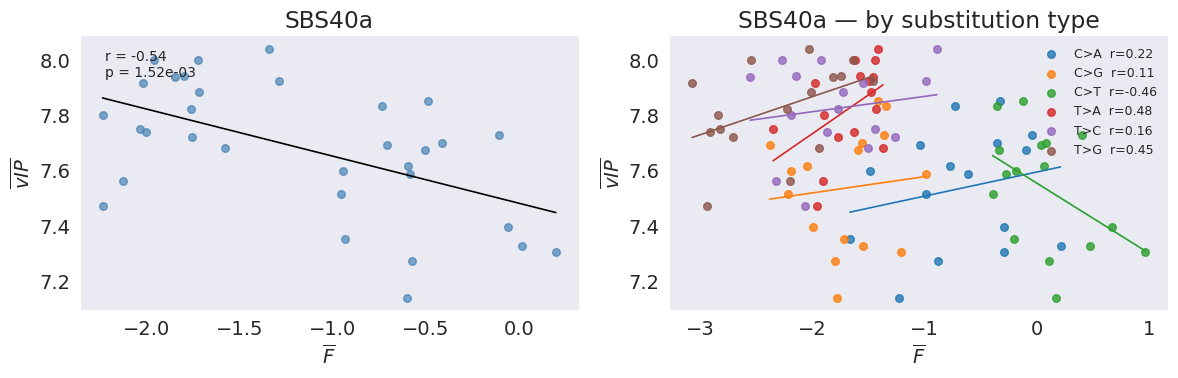

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS40b_no_outlier.svg


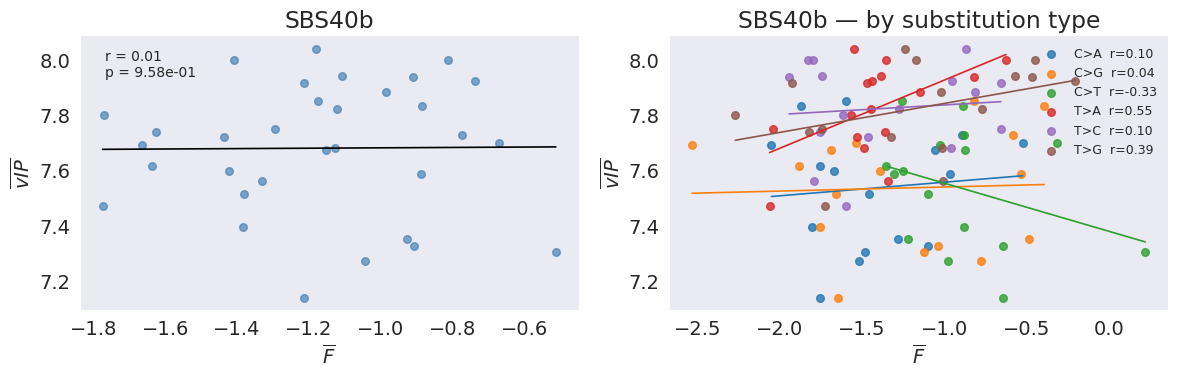

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS40c_no_outlier.svg


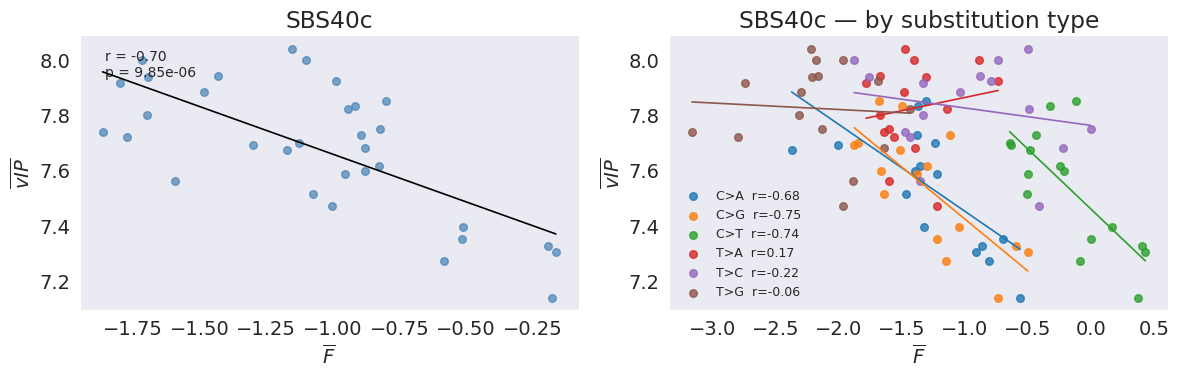

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS41_no_outlier.svg


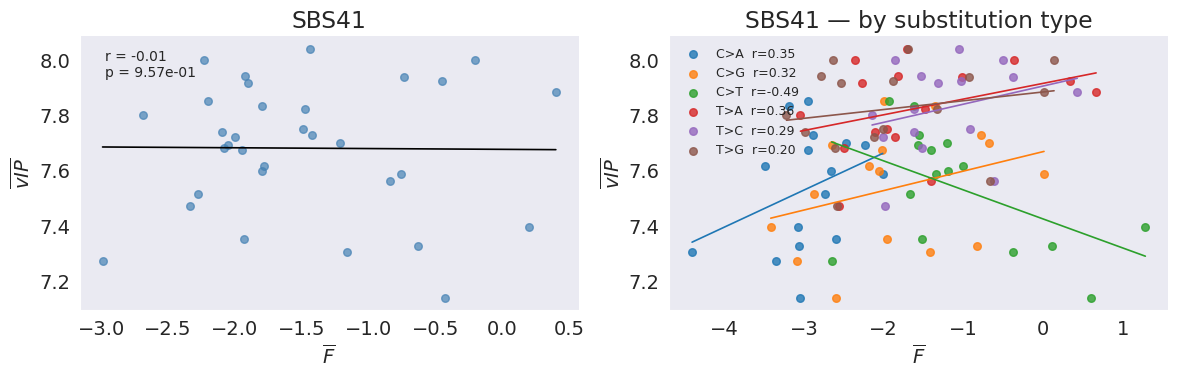

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS42_no_outlier.svg


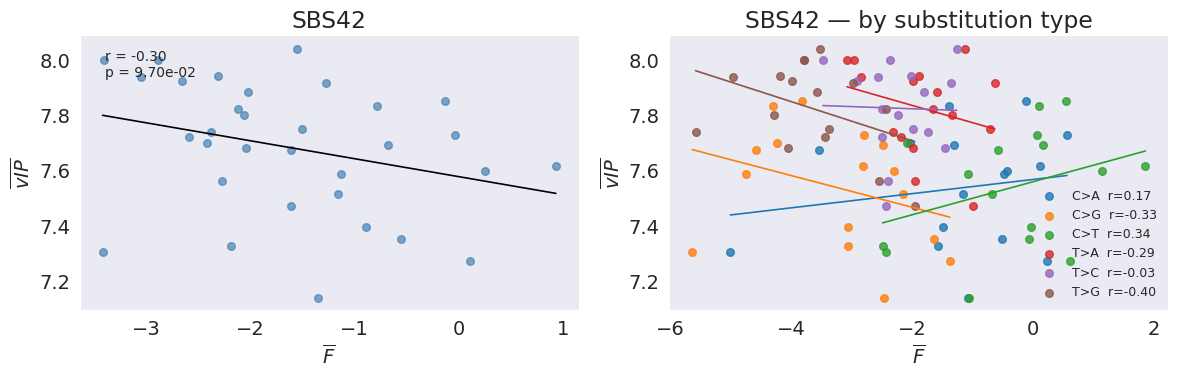

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS43_no_outlier.svg


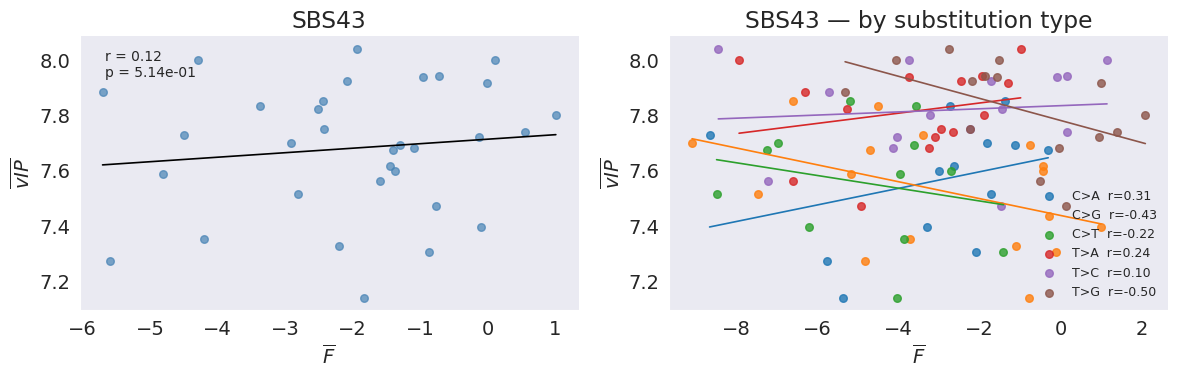

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS44_no_outlier.svg


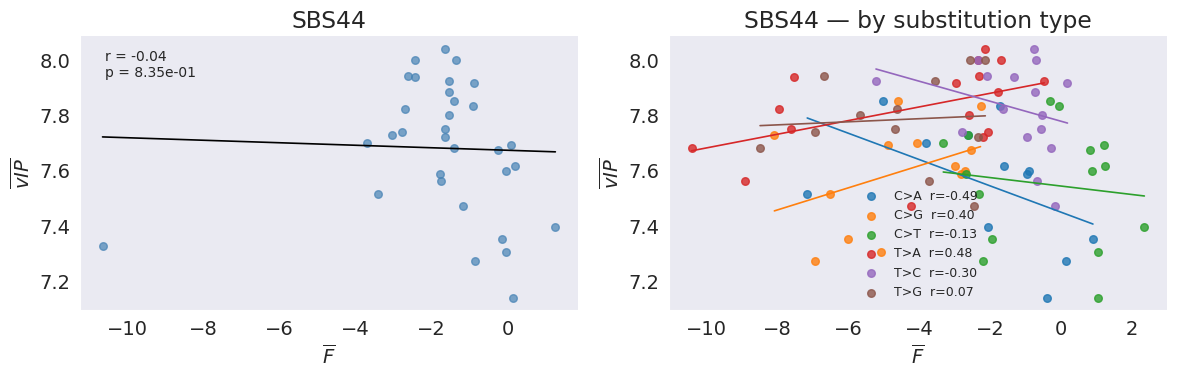

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS45_no_outlier.svg


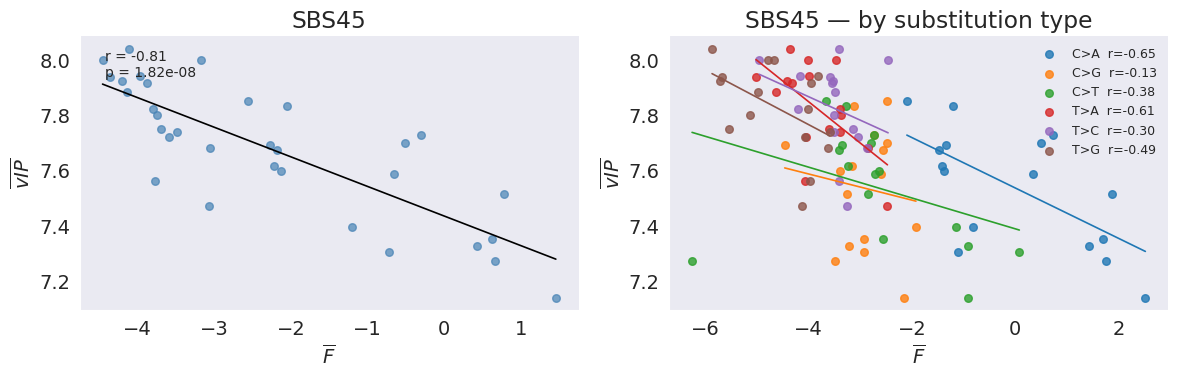

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS46_no_outlier.svg


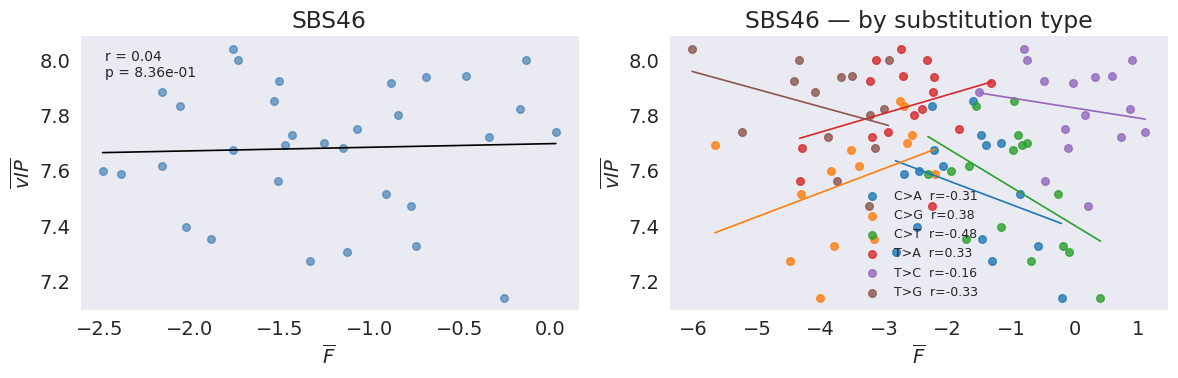

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS47_no_outlier.svg


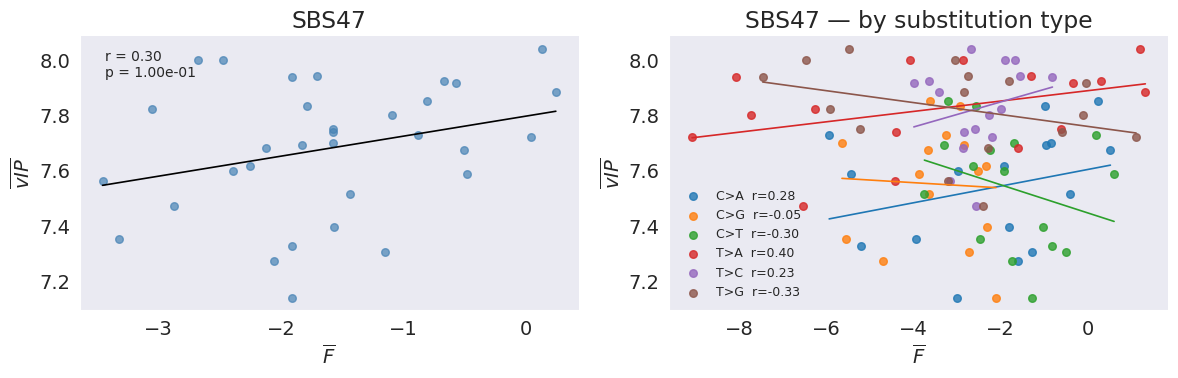

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS48_no_outlier.svg


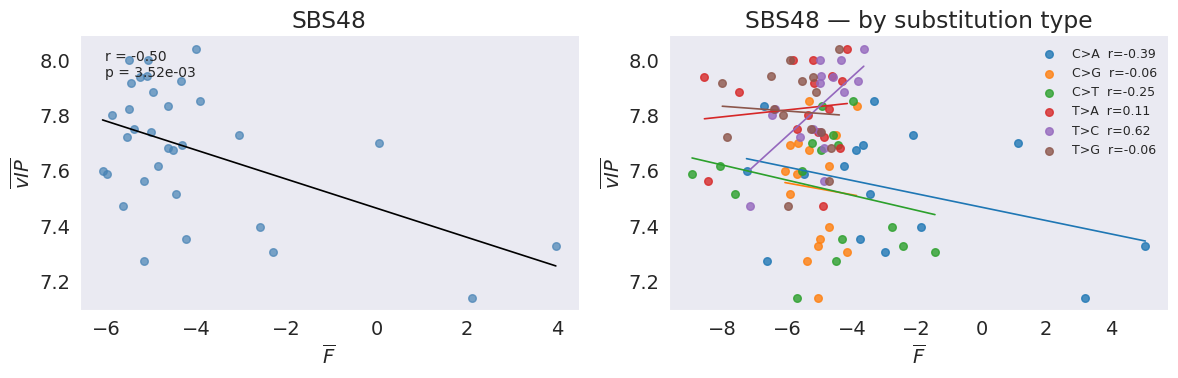

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS49_no_outlier.svg


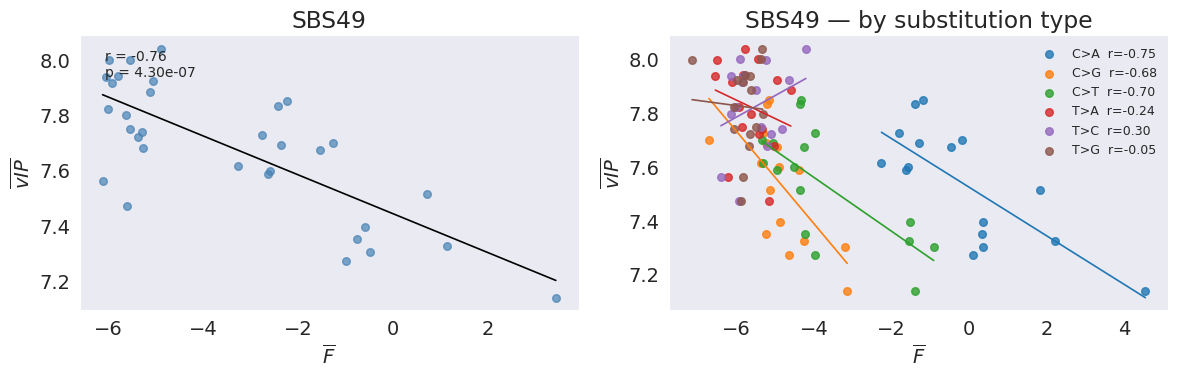

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS50_no_outlier.svg


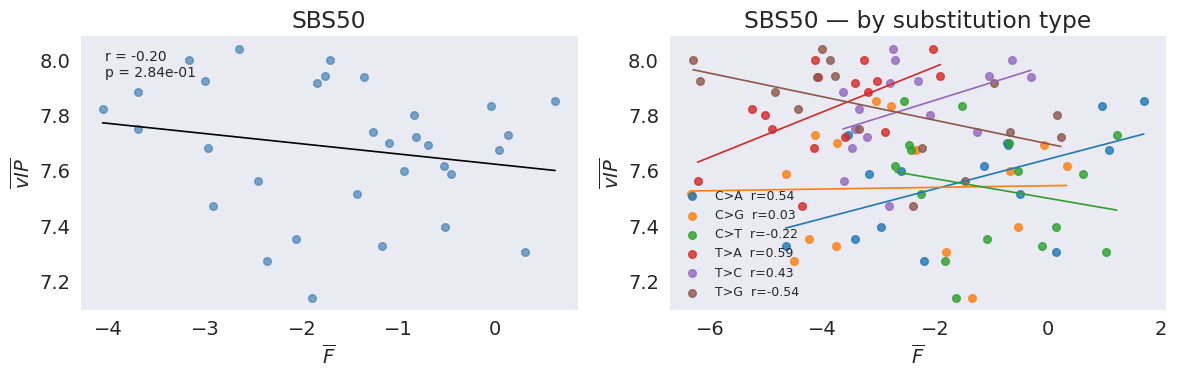

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS51_no_outlier.svg


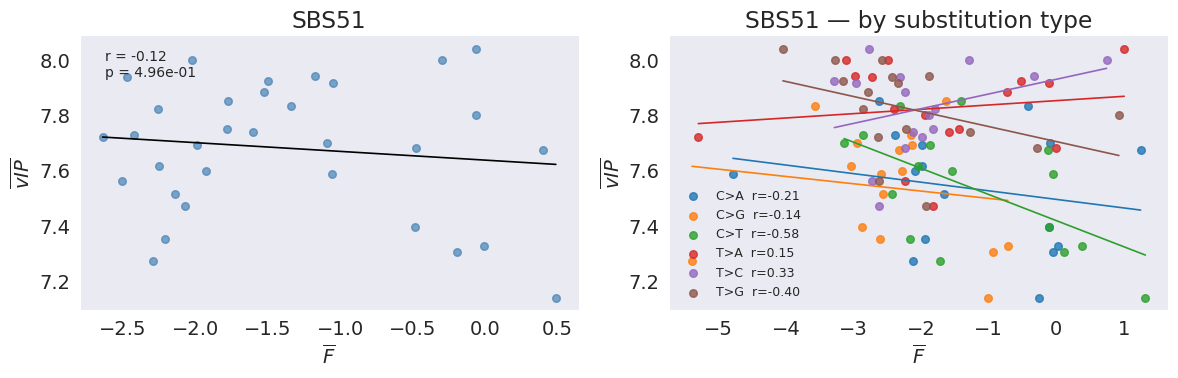

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS52_no_outlier.svg


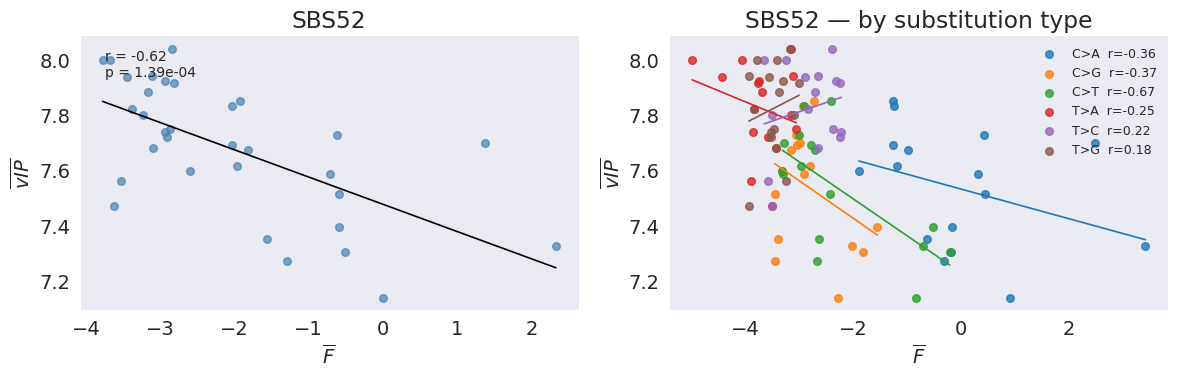

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS53_no_outlier.svg


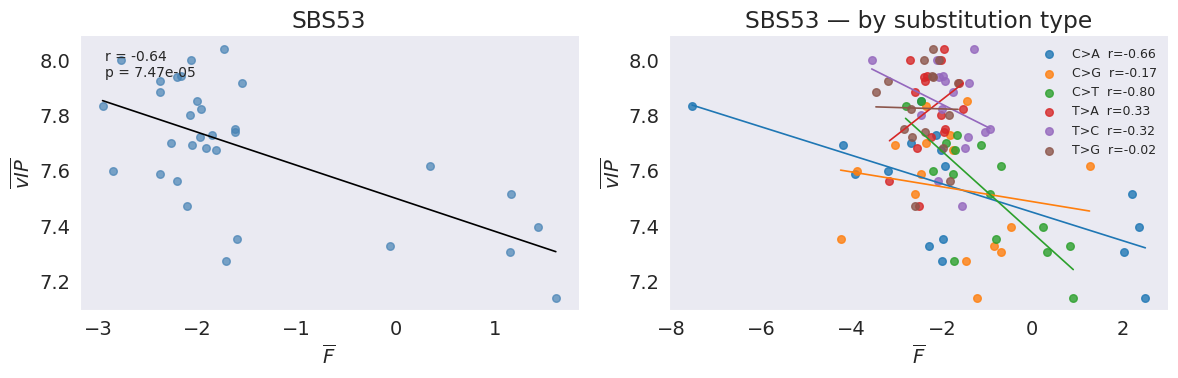

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS54_no_outlier.svg


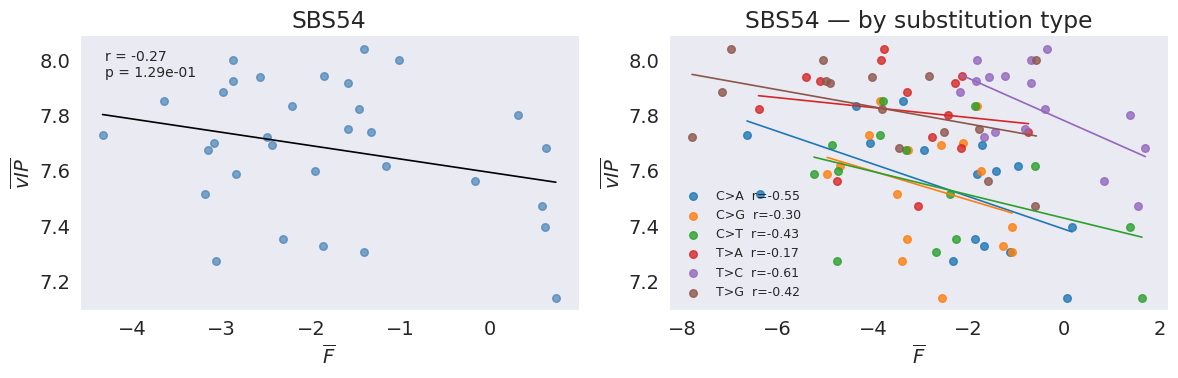

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS55_no_outlier.svg


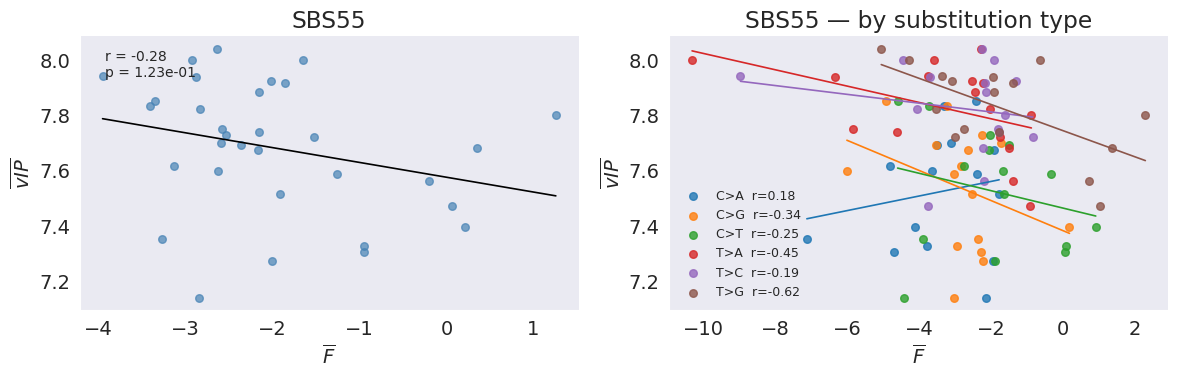

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS56_no_outlier.svg


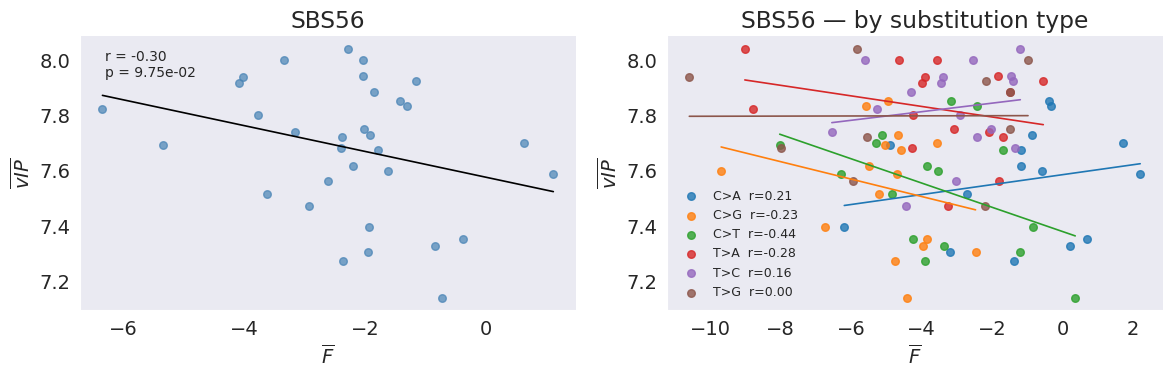

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS57_no_outlier.svg


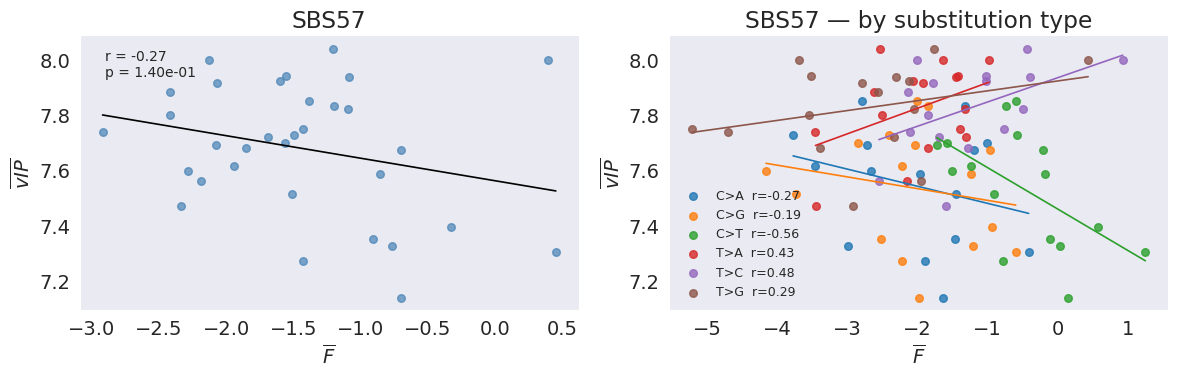

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS58_no_outlier.svg


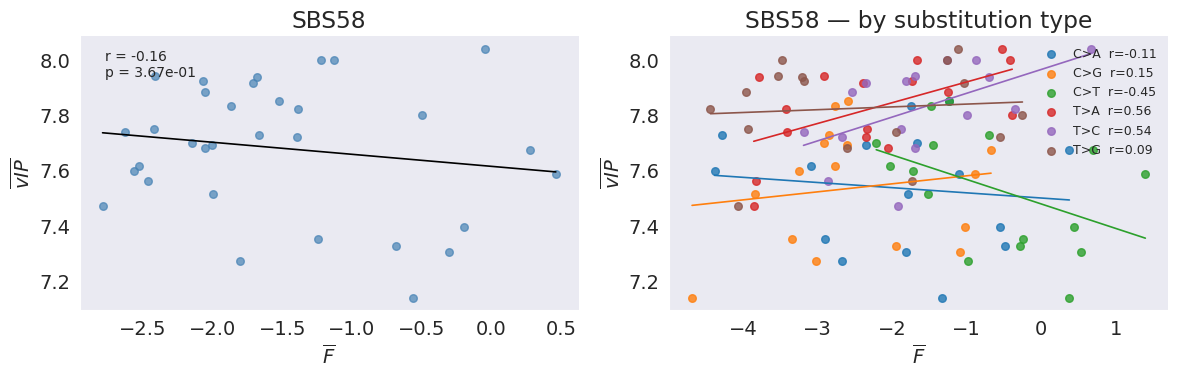

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS59_no_outlier.svg


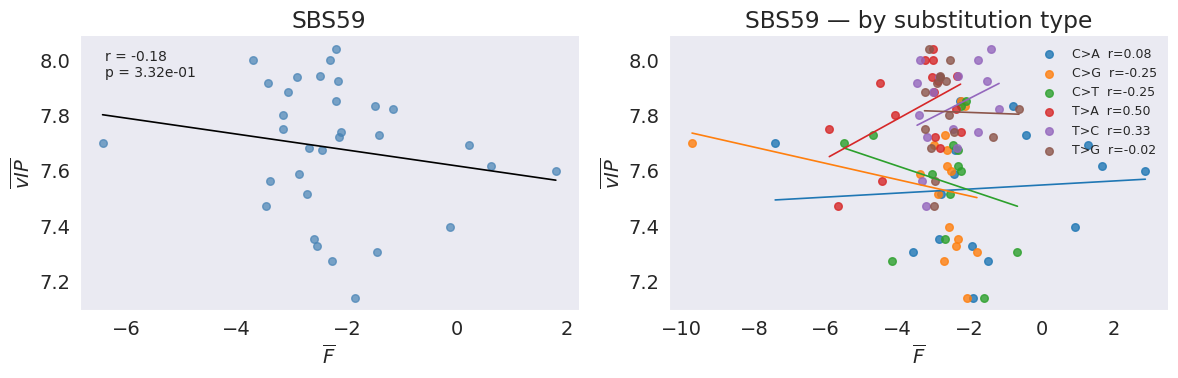

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS60_no_outlier.svg


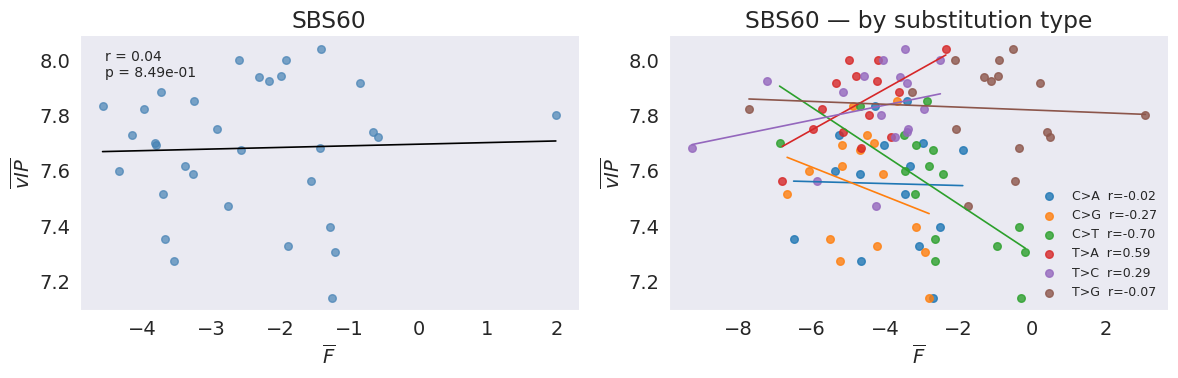

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS84_no_outlier.svg


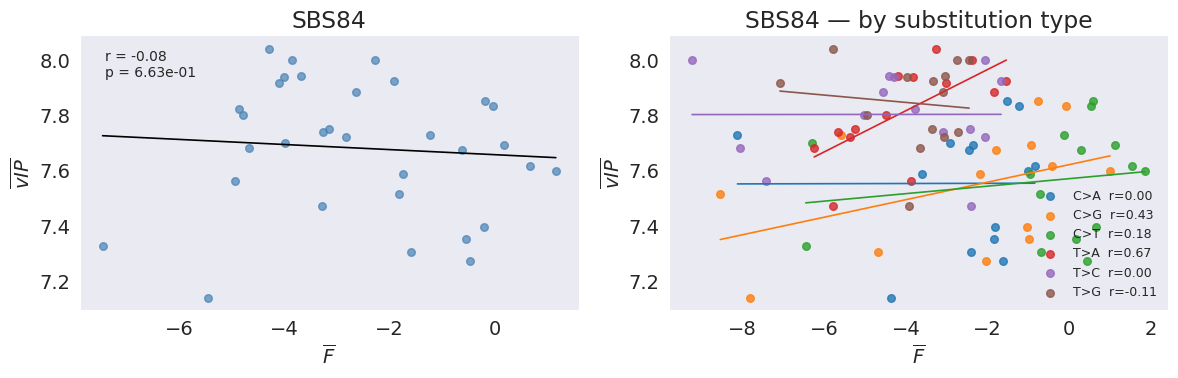

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS85_no_outlier.svg


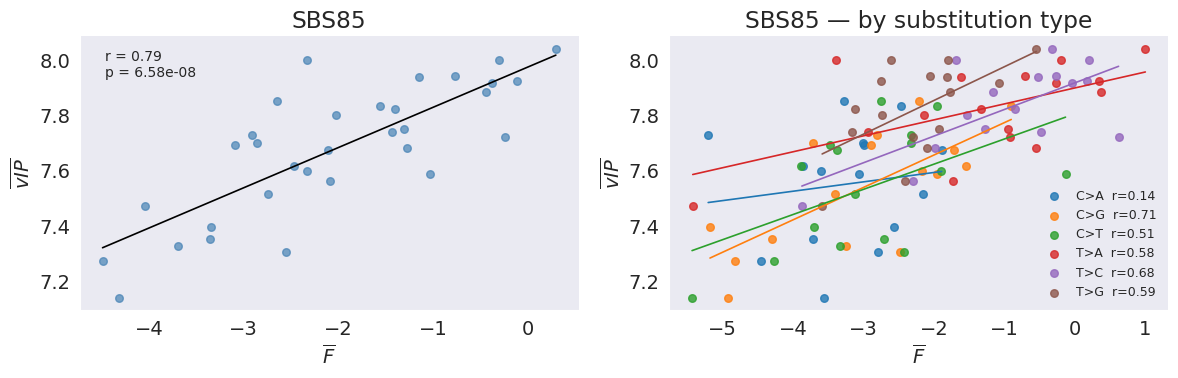

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS86_no_outlier.svg


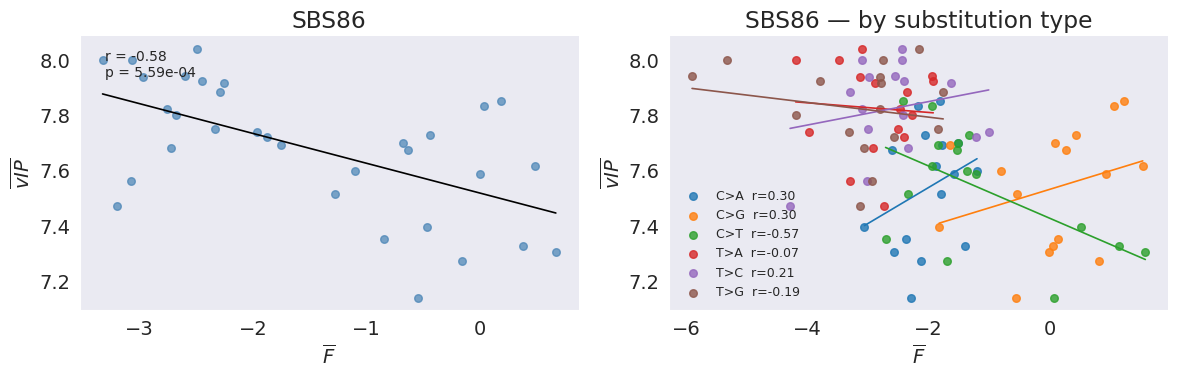

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS87_no_outlier.svg


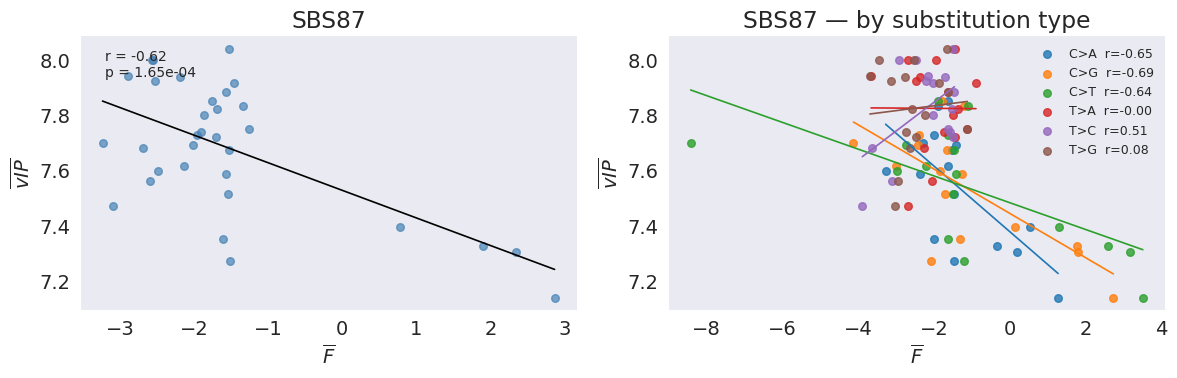

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS88_no_outlier.svg


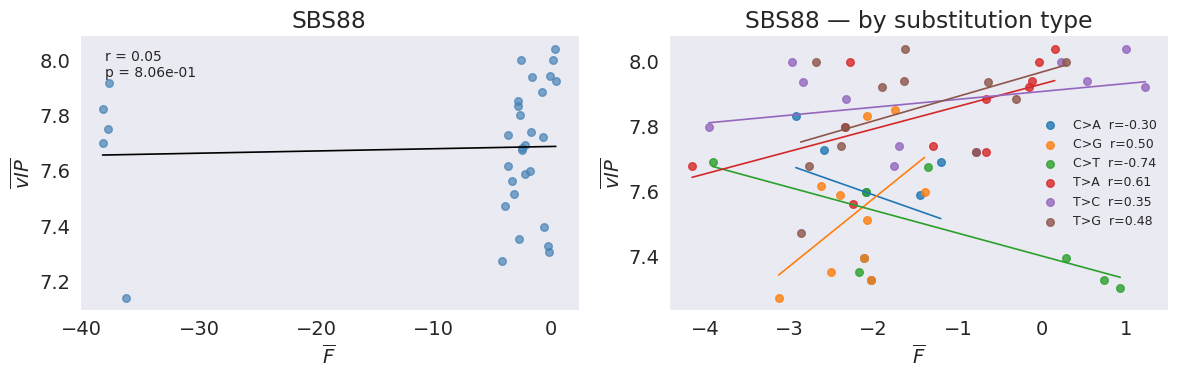

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS89_no_outlier.svg


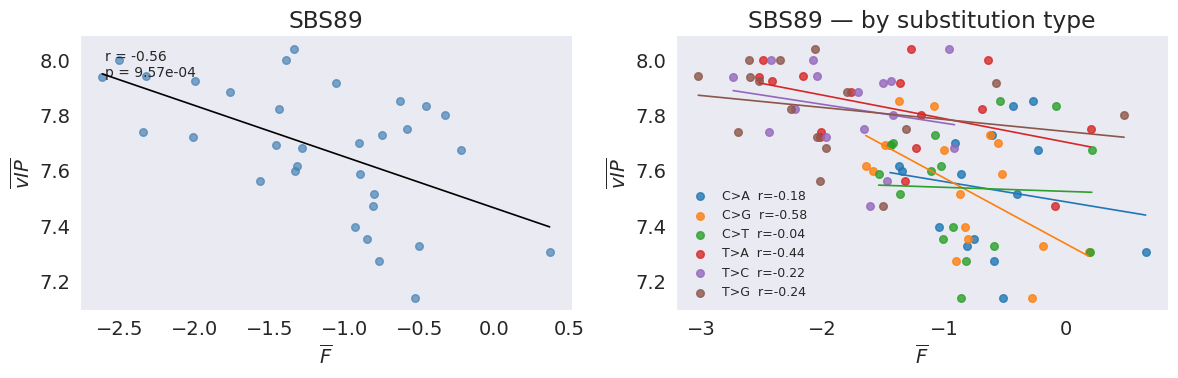

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS90_no_outlier.svg


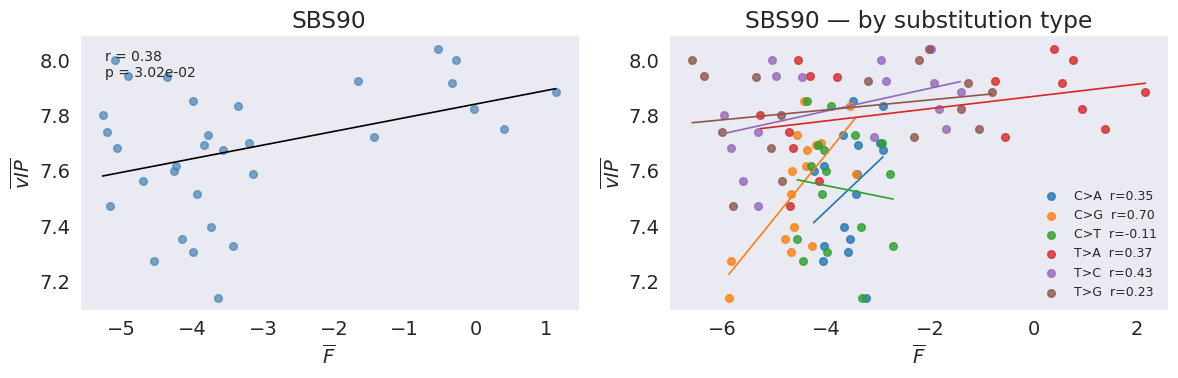

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS91_no_outlier.svg


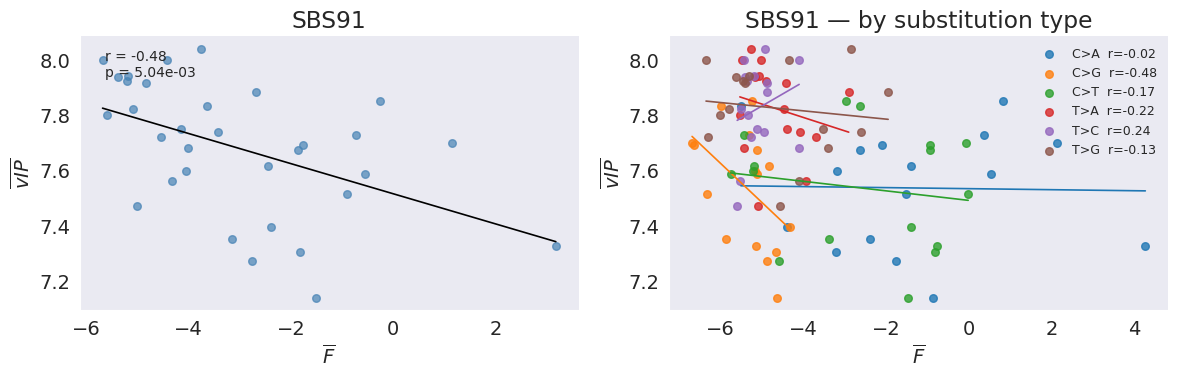

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS92_no_outlier.svg


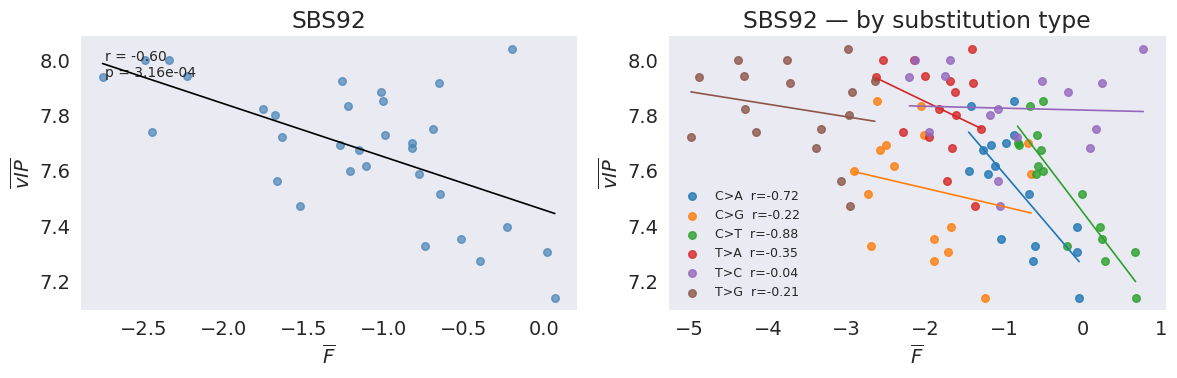

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS93_no_outlier.svg


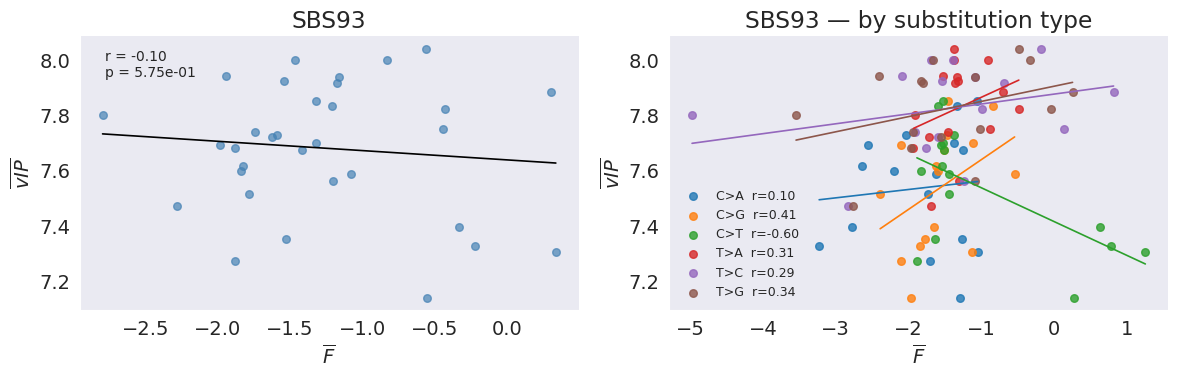

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS94_no_outlier.svg


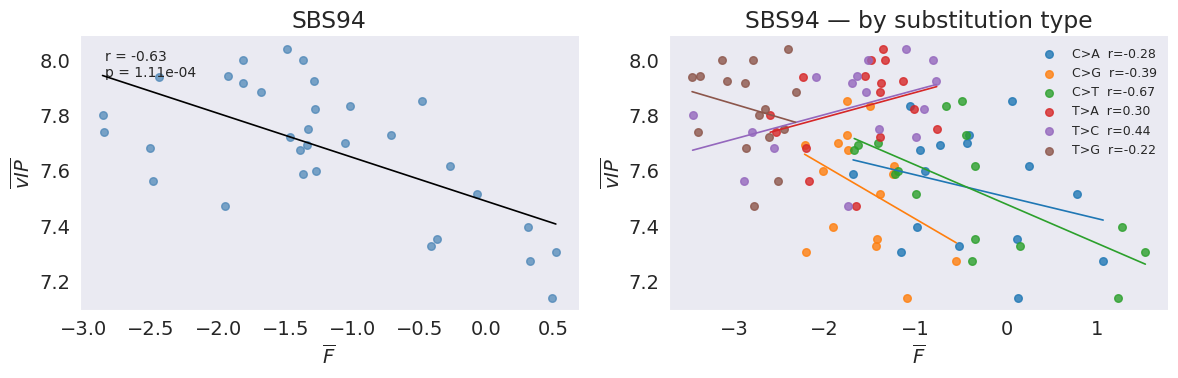

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS95_no_outlier.svg


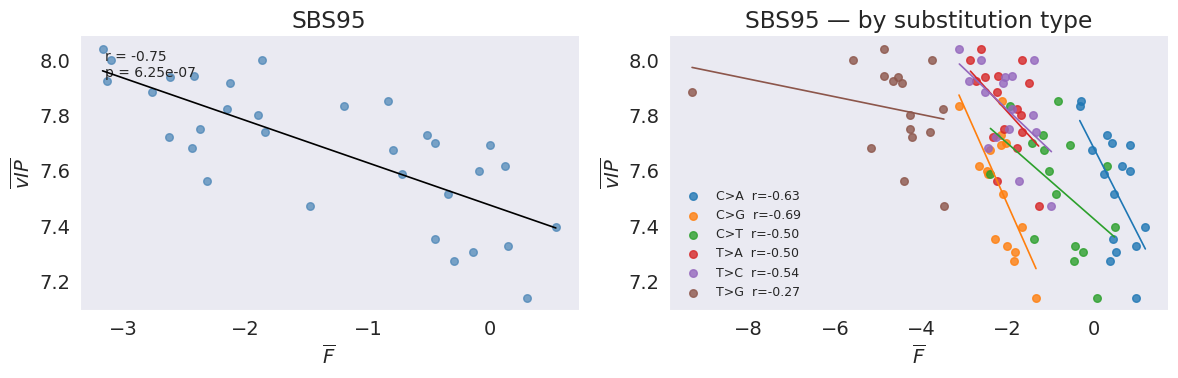

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS96_no_outlier.svg


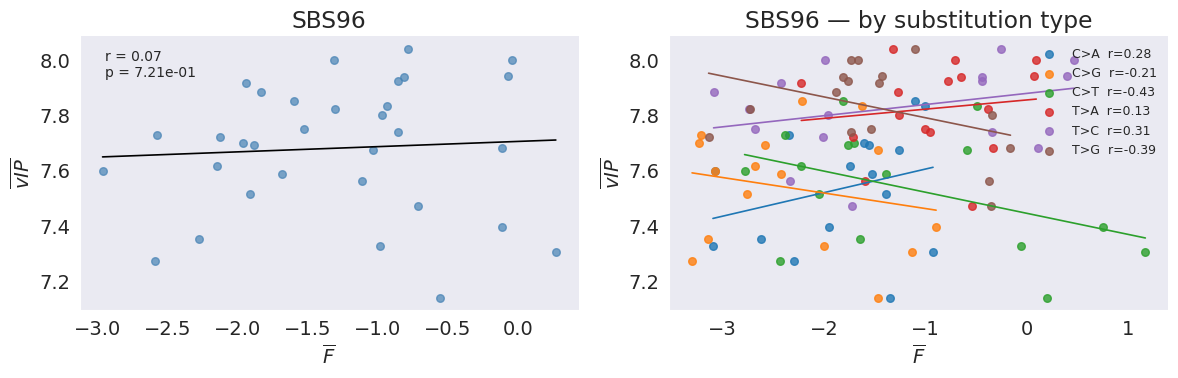

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS97_no_outlier.svg


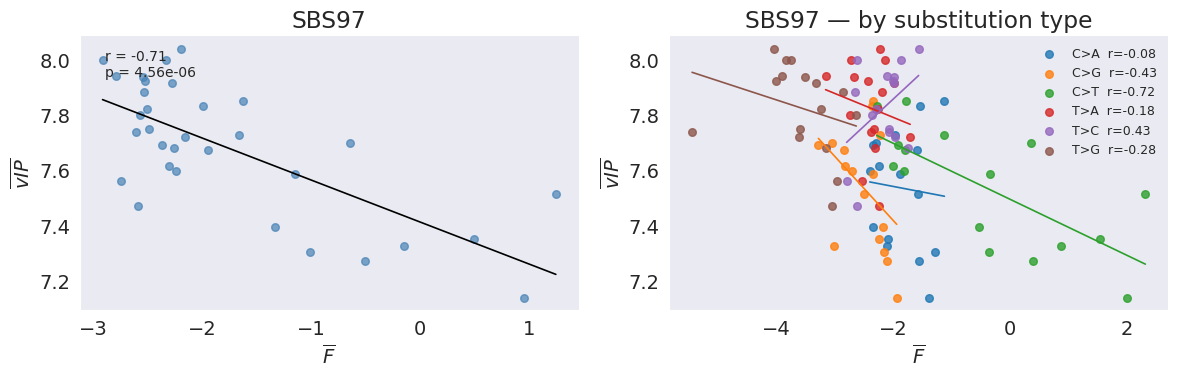

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS98_no_outlier.svg


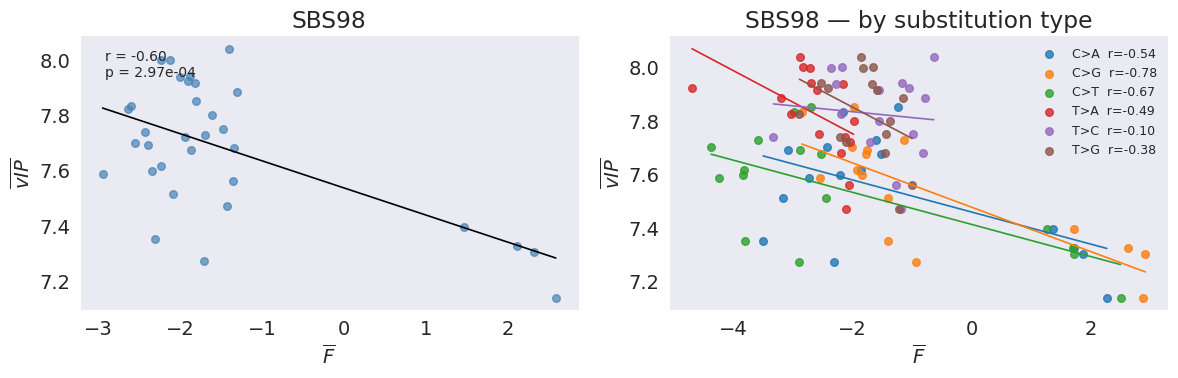

Figure saved to /home/ben/projects/vIP/paper/outputs/cosmic/supplementary/detail_signatures/details_SBS99_no_outlier.svg


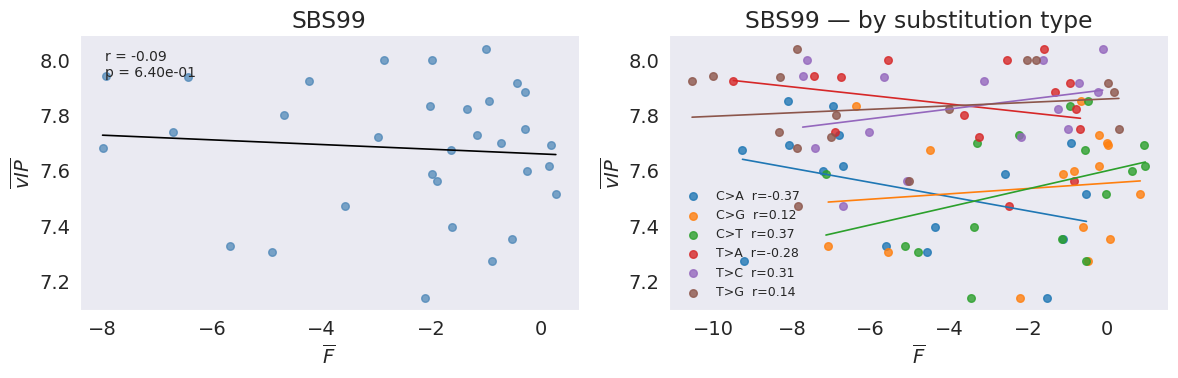

In [25]:
MIN_PROB = 0
MIN_PROB = 1e-6

sig_names = ["SBS4", "SBS85"]

sig_names = signature_etiology["signature"].to_list()

sbs_types_ordered = sorted(
    cosmic_signatures_df.select(["ref", "alt"])
    .unique()
    .map_rows(lambda r: f"{r[0]}>{r[1]}")
    .to_series()
    .to_list()
)
sbs_colors = {t: mpl.cm.tab10(i) for i, t in enumerate(sbs_types_ordered)}

# Per-sbs_type data for right plot (hue)
scatter_per_type = {}
for sig in sig_names:
    rows = []
    for ref, alt in sorted(
        cosmic_signatures_df.select(["ref", "alt"]).unique().iter_rows()
    ):
        sub = (
            cosmic_signatures_df.filter(pl.col("ref") == ref, pl.col("alt") == alt)
            .join(kmer_context_bar, on="context")
            .with_columns(
                pl.col("context")
                .map_elements(
                    VIPER.compute_double_strand_score, return_dtype=pl.Float64
                )
                .alias("vip"),
                pl.lit(f"{ref}>{alt}").alias("sbs_type"),
            )
            .filter(pl.col(sig) > MIN_PROB)
            .with_columns(
                np.log(pl.col(sig) / pl.col("frequencies")).alias("F"),
            )
            .filter(pl.col("F").is_finite())
            .select(["context", "sbs_type", "vip", "F"])
        )
        rows.append(sub)
    scatter_per_type[sig] = pl.concat(rows)


def add_regression_line(ax, x, y, color="black", lw=1.2):
    slope, intercept, *_ = stats.linregress(x, y)
    x_range = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_range, slope * x_range + intercept, color=color, linewidth=lw, zorder=5)


for sig in sig_names:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Left: same aggregation as signature_correlation_bar (32 points, mean across sbs types)
    df_bar = cosmic_signatures_df_bar.select(["context", "vip", sig]).rename({sig: "F"})

    axs[0].grid(False)
    r, p = stats.pearsonr(df_bar["F"], df_bar["vip"])
    axs[0].scatter(df_bar["F"], df_bar["vip"], alpha=0.7, s=30, color="steelblue")
    add_regression_line(axs[0], df_bar["F"], df_bar["vip"])
    axs[0].text(
        0.05,
        0.95,
        f"r = {r:.2f}\np = {p:.2e}",
        transform=axs[0].transAxes,
        va="top",
        fontsize=10,
    )
    axs[0].set_title(sig)
    axs[0].set_xlabel(r"$\overline{F}$")
    axs[0].set_ylabel(r"$\overline{vIP}$")
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)

    # Right: per substitution type (16 points × 6 types)
    axs[1].grid(False)
    df_type = scatter_per_type[sig]
    for sbs_type in sbs_types_ordered:
        sub = df_type.filter(pl.col("sbs_type") == sbs_type)
        if len(sub) == 0:
            continue
        x, y = sub["F"].to_numpy(), sub["vip"].to_numpy()
        r_sub, _ = stats.pearsonr(x, y)
        axs[1].scatter(
            x,
            y,
            color=sbs_colors[sbs_type],
            label=f"{sbs_type}  r={r_sub:.2f}",
            alpha=0.8,
            s=30,
        )

        add_regression_line(axs[1], x, y, color=sbs_colors[sbs_type])
    axs[1].set_title(f"{sig} — by substitution type")
    axs[1].set_xlabel(r"$\overline{F}$")
    axs[1].set_ylabel(r"$\overline{vIP}$")
    axs[1].legend(fontsize=9, frameon=False)
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)

    plt.tight_layout()
    if GENERATE_RESULTS:
        output_path = (
            PROJECT_DIR
            / "outputs"
            / "cosmic"
            / "supplementary"
            / "detail_signatures"
            / f"details_{sig}{'_no_outlier' if MIN_PROB > 0 else ''}.svg"
        )
        if not output_path.parent.exists():
            output_path.parent.mkdir(parents=True)
        fig.savefig(
            output_path,
            bbox_inches="tight",
        )
        print(f"Figure saved to {output_path}")

    plt.show()